                                                         PROJECT PHASE 3

                Title: Leveraging Health Data to Predict Infant Survival and Wellbeing from Pregnancy to Early Childhood

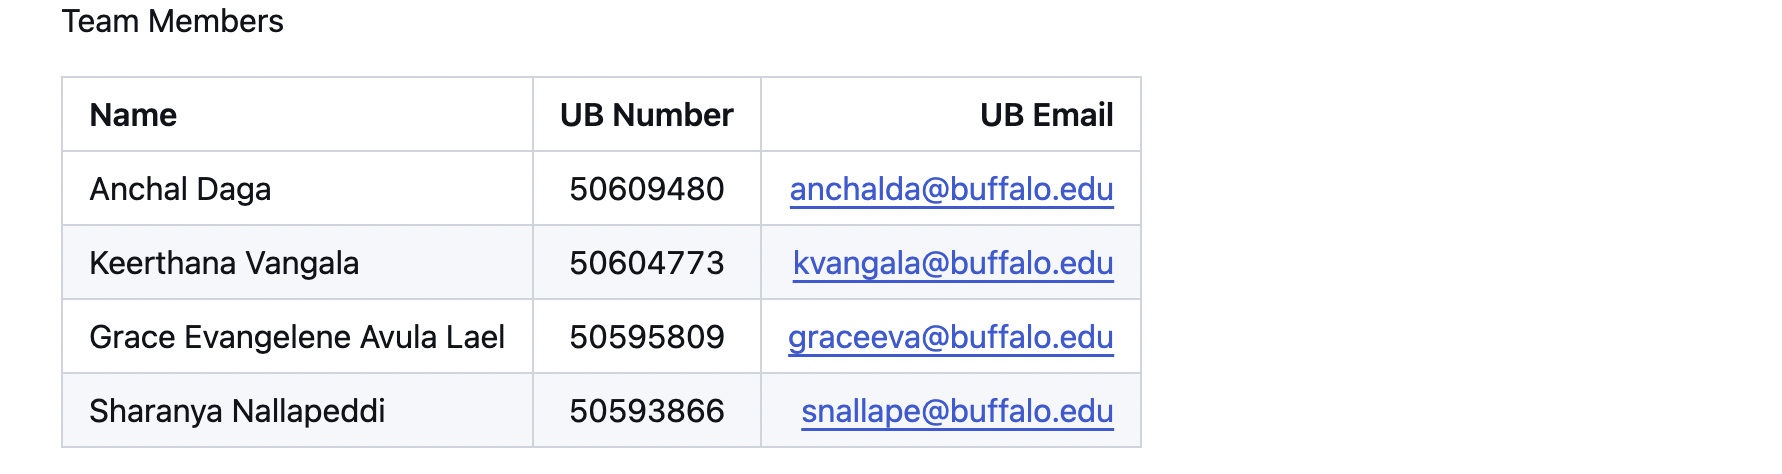

The team's collective data cleaning steps, each team member's individual EDA, and their Phase 2 ML/MR data models are all included in this file. 

In [1]:
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.preprocessing import LabelEncoder

import re
import numpy as np

In [2]:
#load the data from the local folder
file_path = '/Users/sharanya/Downloads/DIC/50604773_50609480_50595809_50593866_Phase_2/Raw_Data_Updated.csv' 

dataset = pd.read_csv(file_path)

Below are the performed data cleaning steps

In [3]:
#Step 1 :  Remove duplicates rows

dataset.drop_duplicates(keep='first', inplace=True)

#Step 2 : Remove irrelevant column like Year Code
dataset.columns = dataset.columns.str.strip()
dataset.drop(columns=['Year Code'], errors='ignore', inplace=True)

#Step 3 : Remove irrelevant data
unwanted_regions = [ '', 'Fragile and conflict affected situations', 'Heavily indebted poor countries (HIPC)', 'High income', 'IBRD only', 'IDA & IBRD total', 'IDA blend', 'IDA only', 'IDA total', 'Late-demographic dividend', 'Early-demographic dividend', 'Post-demographic dividend', 'Pre-demographic dividend', 'Low & middle income', 'Least developed countries: UN classification', 'Low income', 'Lower middle income', 'Not classified', 'OECD members', 'Other small states', 'South Asia (IDA & IBRD)', 'Upper middle income', 'World' ]
dataset_cleaned = dataset[~dataset['Region Name'].isin(unwanted_regions)] 


# Step 4 - Handling Negative Values
column_names = [
    'Life expectancy at birth, female (years) [SP.DYN.LE00.FE.IN]',
    'Number of infant deaths, female [SH.DTH.IMRT.FE]',
    'Number of maternal deaths [SH.MMR.DTHS]',
    'Number of stillbirths [SH.DTH.STLB]'
]
for column_name in column_names:
    dataset_cleaned.loc[:, column_name] = pd.to_numeric(dataset_cleaned[column_name], errors='coerce')
dataset_cleaned2 = dataset_cleaned[(dataset_cleaned[column_names] >= 0).all(axis=1)]


#Step 5 - Standardizing Categorical Data
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

dataset_cleaned2['Region Code Numeric'] = label_encoder.fit_transform(dataset_cleaned2['Region Code'])
region_code_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

#Step 6 - Converting Year to Date time
dataset_cleaned2['Year'] = pd.to_datetime(dataset_cleaned2['Year'], errors='coerce', format='%Y').dt.year

#Step 7 - Renaming columns
dataset_cleaned2.columns = dataset_cleaned2.columns.str.replace(r'\s*\[.*?\]', '', regex=True) 
dataset_cleaned2.columns = dataset_cleaned2.columns.str.replace('_', ' ')

#Step 8
invalid_value = ".."
invalid_percentage = (dataset_cleaned2 == invalid_value).sum() / len(dataset_cleaned2) * 100
# Identify columns to drop (where invalid percentage is more than 80%)
columns_to_drop = invalid_percentage[invalid_percentage > 84].index
data_cleaned_step1 = dataset_cleaned2.drop(columns=columns_to_drop)
data_cleaned_step1["Mortality rate, infant (per 1,000 live births)"] = pd.to_numeric(data_cleaned_step1["Mortality rate, infant (per 1,000 live births)"], errors='coerce')
data_cleaned_step1["Birth rate, crude (per 1,000 people)"] = pd.to_numeric(data_cleaned_step1["Birth rate, crude (per 1,000 people)"], errors='coerce')
data_cleaned_step1["Infant Mortality Rate to Birth Rate Ratio"] = data_cleaned_step1["Mortality rate, infant (per 1,000 live births)"] / data_cleaned_step1["Birth rate, crude (per 1,000 people)"]
# Extract the relevant column names for regions and the "Infant Mortality Rate to Birth Rate Ratio"
region_column = 'Region Name'
ratio_column = 'Infant Mortality Rate to Birth Rate Ratio'
# Create a copy of the data to avoid modifying the first 3 columns
data_modified = data_cleaned_step1.copy()
# List of columns that should not be modified (first 3 columns)
unmodifiable_columns = data_modified.columns[:3]
def replace_dot_dot_values(data, region_column, ratio_column):
    regions = data[region_column].unique()

    for region in regions:
        region_data = data[data[region_column] == region]
        
        for column in data.columns:
            if column not in unmodifiable_columns and column != region_column and column != ratio_column:
                # Get total number of ".." in the column for the region
                region_dot_dot_count = (region_data[column] == "..").sum()
                region_total_count = region_data.shape[0]
                region_dot_dot_percentage = (region_dot_dot_count / region_total_count) * 100

                # If ".." is more than 70% of the data for the region
                if region_dot_dot_percentage > 70:
                    current_region_ratio = data.loc[data[region_column] == region, ratio_column].replace("..", pd.NA).astype(float).mean()
                    similar_region = data[(data[region_column] != region) &
                                          (abs(data[ratio_column].replace("..", pd.NA).astype(float) - current_region_ratio) < 0.05)]
                    if not similar_region.empty:
                        try:
                            replacement_value = pd.to_numeric(similar_region[column], errors='coerce').mean()
                            data.loc[data[region_column] == region, column] = data.loc[data[region_column] == region, column].replace("..", replacement_value)
                        except:
                            pass
                else:
                    try:
                        region_mean_value = pd.to_numeric(region_data[column], errors='coerce').mean()
                        data.loc[data[region_column] == region, column] = data.loc[data[region_column] == region, column].replace("..", region_mean_value)
                    except:
                        pass

replace_dot_dot_values(data_modified, region_column, ratio_column)

#Step 9 
problematic_columns = ["Newborns protected against tetanus (%)", 
                       "Vitamin A supplementation coverage rate (% of children ages 6-59 months)"]
data_modified[problematic_columns] = data_modified[problematic_columns].replace("..", pd.NA)

# Convert columns to numeric & fill missing values with column means
for col in problematic_columns:
    data_modified[col] = pd.to_numeric(data_modified[col], errors="coerce") 
    data_modified[col].fillna(data_modified[col].mean(), inplace=True)       


# Step 10 - Feature Engineering
# Convert relevant columns to numeric, forcing errors to NaN
cols_to_convert = [
    'Birth rate, crude (per 1,000 people)',
    'Death rate, crude (per 1,000 people)',
    'Immunization, HepB3 (% of one-year-old children)',
    'Immunization, measles second dose (% of children by the nationally recommended age)',
    'Life expectancy at birth, female (years)',
    'Life expectancy at birth, male (years)',
    'Mortality rate, infant (per 1,000 live births)',
    'Mortality rate, neonatal (per 1,000 live births)',
    'Prevalence of hypertension, pregnant women (% of pregnant women adults ages 30-79)',
    'Mortality rate, infant, female (per 1,000 live births)',
    'Mortality rate, infant, male (per 1,000 live births)',
    'Maternal mortality ratio (modeled estimate, per 100,000 live births)'
]
dataset_cleaned2 = data_modified.copy()

# Convert the columns to numeric
for col in cols_to_convert:
    dataset_cleaned2[col] = pd.to_numeric(dataset_cleaned2[col], errors='coerce')

# Birth-Death Ratio
dataset_cleaned2['Birth-Death Ratio'] = dataset_cleaned2['Birth rate, crude (per 1,000 people)'] / dataset_cleaned2['Death rate, crude (per 1,000 people)']

# Avg of HepB3 and Measles second dose immunization rates
dataset_cleaned2['Immunization Efficacy'] = (dataset_cleaned2['Immunization, HepB3 (% of one-year-old children)'] + 
                                             dataset_cleaned2['Immunization, measles second dose (% of children by the nationally recommended age)']) / 2

# Life Expectancy Difference
dataset_cleaned2['Life Expectancy Difference'] = dataset_cleaned2['Life expectancy at birth, female (years)'] - dataset_cleaned2['Life expectancy at birth, male (years)']

# Infant Mortality Rate to Birth Rate Ratio
# dataset_cleaned2['Infant Mortality Rate to Birth Rate Ratio'] = dataset_cleaned2['Mortality rate, infant (per 1,000 live births)'] / dataset_cleaned2['Birth rate, crude (per 1,000 people)']

# Neonatal Mortality Rate to Birth Rate Ratio
dataset_cleaned2['Neonatal Mortality Rate to Birth Rate Ratio'] = dataset_cleaned2['Mortality rate, neonatal (per 1,000 live births)'] / dataset_cleaned2['Birth rate, crude (per 1,000 people)']

# Hypertension to Birth Rate Ratio
dataset_cleaned2['Hypertension to Birth Rate Ratio'] = dataset_cleaned2['Prevalence of hypertension, pregnant women (% of pregnant women adults ages 30-79)'] / dataset_cleaned2['Birth rate, crude (per 1,000 people)']

# Female to Male Infant Mortality
dataset_cleaned2['Female to Male Infant Mortality'] = dataset_cleaned2['Mortality rate, infant, female (per 1,000 live births)'] / dataset_cleaned2['Mortality rate, infant, male (per 1,000 live births)']

# Maternal to Neonatal Mortality
dataset_cleaned2['Maternal to Neonatal Mortality'] = dataset_cleaned2['Maternal mortality ratio (modeled estimate, per 100,000 live births)'] / dataset_cleaned2['Mortality rate, neonatal (per 1,000 live births)']

# Handle potential infinite or NaN values (for cases where division by zero occurs)
dataset_cleaned2.replace([float('inf'), -float('inf')], pd.NA, inplace=True)


#Step 10 - Handling outliers
numeric_cols = dataset_cleaned2.select_dtypes(include=['float64', 'int64']).columns

def handle_outliers_iqr(dataset_cleaned2, col):
    Q1 = dataset_cleaned2[col].quantile(0.25)
    Q3 = dataset_cleaned2[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    median_value = dataset_cleaned2[col].median()

    # Replace outliers with the median value using .loc to avoid the warning
    dataset_cleaned2.loc[(dataset_cleaned2[col] < lower_bound) | (dataset_cleaned2[col] > upper_bound), col] = median_value

for col in numeric_cols:
    handle_outliers_iqr(dataset_cleaned2, col)


# Step 11: rounding off decimal points
# Function to truncate to 2 decimal places without rounding
def truncate_to_two_decimals(x):
    return np.floor(x * 100) / 100
# Select all columns starting from the 4th column onward (index 3 since Python uses 0-based indexing)
numeric_cols = dataset_cleaned2.iloc[:, 3:]

# Convert to numeric and truncate values to 2 decimal places without rounding
dataset_cleaned2.iloc[:, 3:] = numeric_cols.apply(pd.to_numeric, errors='coerce').applymap(truncate_to_two_decimals)


Below are the steps to save the updated DataFrame to a CSV file

In [4]:
file_path = '~/Downloads/phase3.csv'
dataset_cleaned2.to_csv(file_path, index=False)

phase3.csv" is used as an input for data loading. Each one of us has performed individual EDA and derived suitable machine learning (ML), statistical modeling, or regression (MR) algorithms for each of our questions and corresponding hypotheses. Following is the work performed by each team member, which is put under each their name.

Student Name: Keerthana Vangala
Student ID: 50604773
Mail ID: vangala@buffalo.edu

Exploratory data analysis (EDA):

The questions & hypothesis taken into account for the EDA are listed below:

Question 1. What is the association between immunization coverage ( HepB, Polio, Measles) and infant mortality?

Hypotheses 1: Higher immunization rates for HepB, Polio, and Measles are linked with lower infant mortality rates. 
If this is correct it means that vaccination given in the 1st one year to a baby are protecting them against the respective diseases.

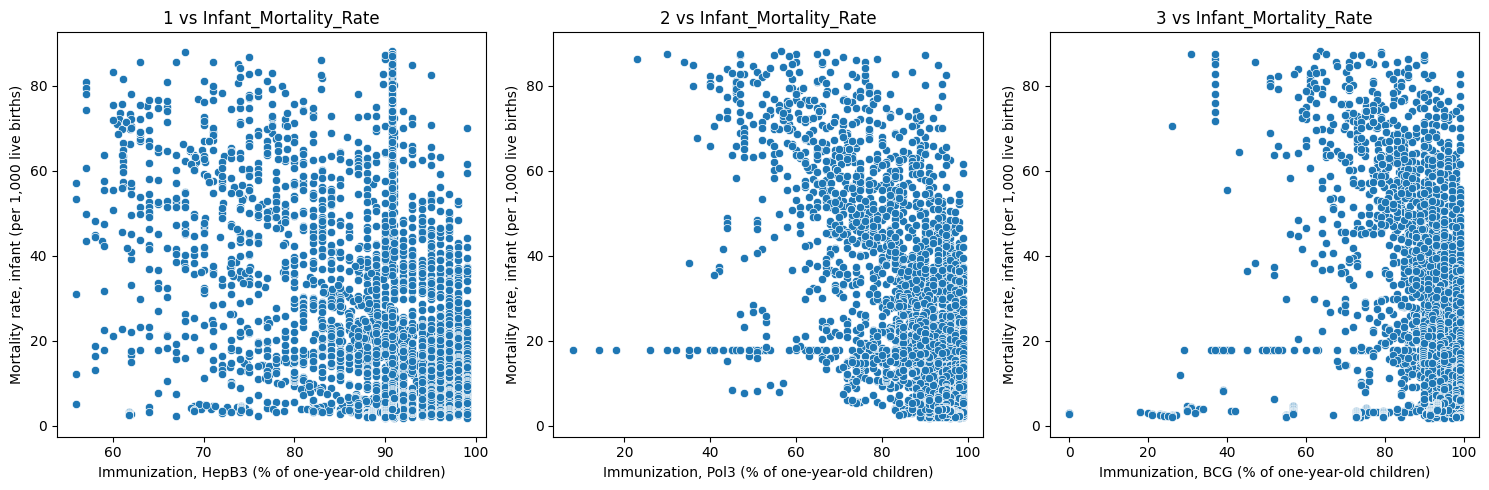

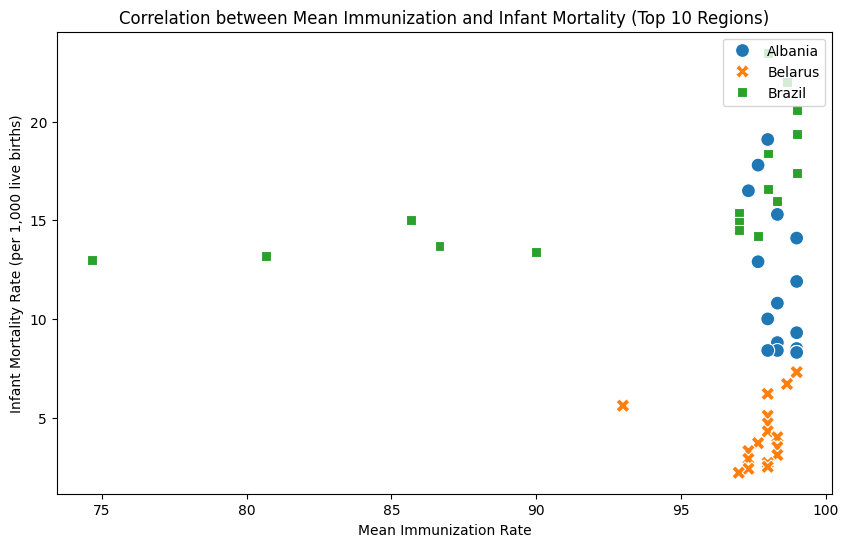

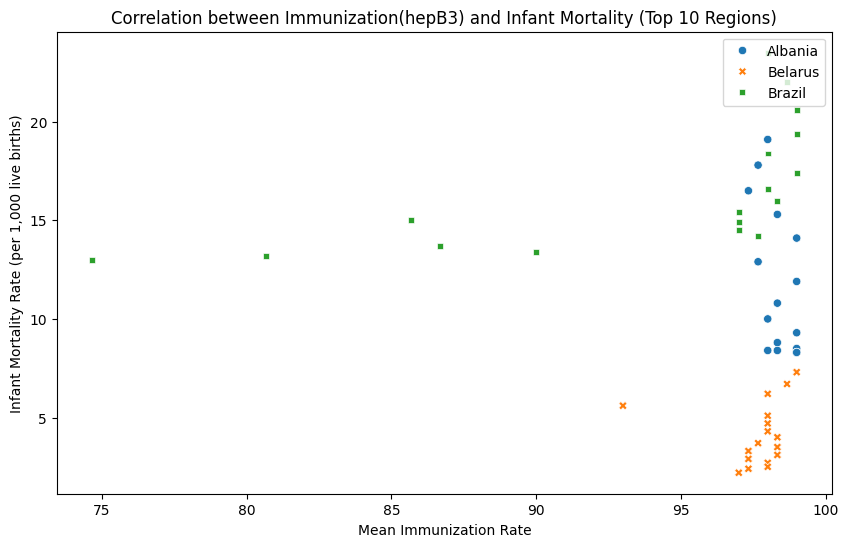

Mean_Immunization  \
Mean_Immunization                                        1.000000   
Mortality rate, infant (per 1,000 live births)          -0.563622   

                                                Mortality rate, infant (per 1,000 live births)  
Mean_Immunization                                                                    -0.563622  
Mortality rate, infant (per 1,000 live births)                                        1.000000

In [5]:
#Hypotheses 1: Higher immunization rates for HepB, Polio, and Measles are linked with lower infant mortality rates. 
#If this is correct it means that vaccination given in the 1st one year to a baby are protecting them against the respective diseases.

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = '/Users/sharanya/Downloads/phase3.csv' 

df = pd.read_csv(file_path)
All_3 = df[['Immunization, HepB3 (% of one-year-old children)', 'Immunization, BCG (% of one-year-old children)',
           'Immunization, Pol3 (% of one-year-old children)', 'Mortality rate, infant (per 1,000 live births)']]

# Drop rows with missing values
df = df.dropna()
# Scatter plots
plt.figure(figsize=(15, 5))
for i, col in enumerate(['Immunization, HepB3 (% of one-year-old children)', 
                         'Immunization, Pol3 (% of one-year-old children)', 
                         'Immunization, BCG (% of one-year-old children)']):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(x=df[col], y=df['Mortality rate, infant (per 1,000 live births)'])
    plt.title(f'{i+1} vs Infant_Mortality_Rate')
plt.tight_layout()
plt.show()

#Hypothesis 2: Regoins with higher immunization records will tend to have lower infant mortality rate?
# First, let's calculate the mean of 'Immunization, HepB3', 'Immunization, BCG', and 'Immunization, Pol3' for the top 10 regions
df['Mean_Immunization'] = df[['Immunization, HepB3 (% of one-year-old children)', 
                              'Immunization, BCG (% of one-year-old children)', 
                              'Immunization, Pol3 (% of one-year-old children)']].mean(axis=1)

# Select top 10 regions by 'Mean_Immunization'
top_10_regions = df.nlargest(10, 'Mean_Immunization')['Region Name']

# Filter the dataset to include only these top 10 regions
df_top_10_mean_immun = df[df['Region Name'].isin(top_10_regions)]

# Calculate correlation between 'Mean Immunization' and 'Mortality rate, infant (per 1,000 live births)'
correlation = df_top_10_mean_immun[['Mean_Immunization', 'Mortality rate, infant (per 1,000 live births)']].corr()

# Plot the relationship between 'Mean Immunization' and 'Mortality rate, infant' for these regions
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_top_10_mean_immun, x='Mean_Immunization', y='Mortality rate, infant (per 1,000 live births)', hue='Region Name', style='Region Name', s=100)
plt.title('Correlation between Mean Immunization and Infant Mortality (Top 10 Regions)')
plt.xlabel('Mean Immunization Rate')
plt.ylabel('Infant Mortality Rate (per 1,000 live births)')
plt.legend(loc='upper right')
plt.show()

# Display correlation value
correlation

# First, let's calculate the mean of 'Immunization, HepB3', 'Immunization, BCG', and 'Immunization, Pol3' for the top 10 regions
df['Immunization'] = df[['Immunization, HepB3 (% of one-year-old children)']] 
                    

# Select top 10 regions by 'Mean_Immunization'
mean = df.nlargest(10, 'Immunization')['Region Name']

# Filter the dataset to include only these top 10 regions
mean = df[df['Region Name'].isin(mean)]

# Calculate correlation between 'Mean Immunization' and 'Mortality rate, infant (per 1,000 live births)'
correlation = mean[['Mean_Immunization', 'Mortality rate, infant (per 1,000 live births)']].corr()

# Plot the relationship between 'Mean Immunization' and 'Mortality rate, infant' for these regions
plt.figure(figsize=(10, 6))
# Plot the relationship between 'Mean Immunization' and 'Mortality rate, infant' for these regions
sns.scatterplot(data=df_top_10_mean_immun, x='Mean_Immunization', y='Mortality rate, infant (per 1,000 live births)', hue='Region Name', style='Region Name')
plt.title('Correlation between Immunization(hepB3) and Infant Mortality (Top 10 Regions)')
plt.xlabel('Mean Immunization Rate')
plt.ylabel('Infant Mortality Rate (per 1,000 live births)')
plt.legend(loc='upper right')
plt.show()

# Display correlation value
correlation

Exploratory data analysis (EDA):

The questions & hypothesis taken into account for the EDA are listed below:

Question 2. How does low birth weight correlate outcomes in infants health and infant mortality?

Hypothesis 1: Compared to normal birth weight, low birth weight is linked to a higher risk of infant mortality.
Hypothesis 2: Is there any correlation between babies with lower weight and attendents taking care of the baby?

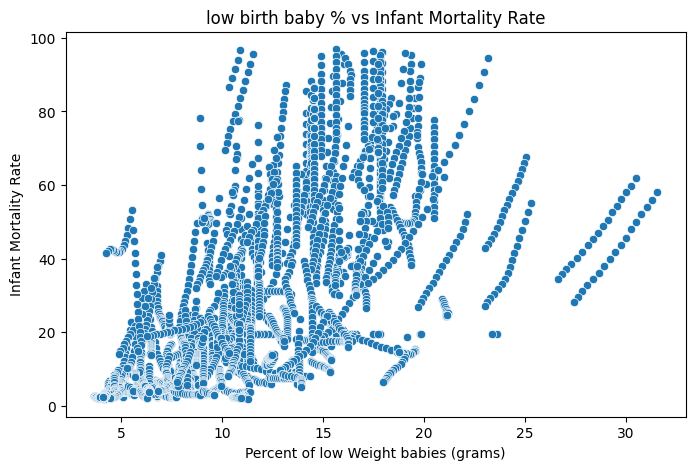

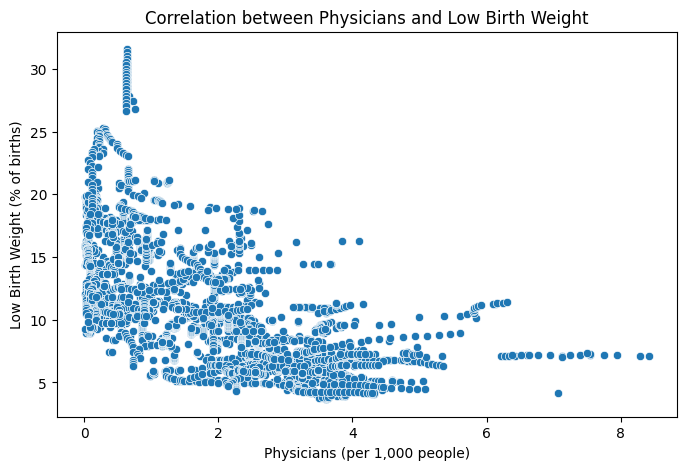

Physicians (per 1,000 people)  \
Physicians (per 1,000 people)                              1.000000   
Low-birthweight babies (% of births)                      -0.631968   

                                      Low-birthweight babies (% of births)  
Physicians (per 1,000 people)                                    -0.631968  
Low-birthweight babies (% of births)                              1.000000

In [6]:
#Hypothesis 1: Compared to normal birth weight, low birth weight is linked to a higher risk of infant mortality.
# Scatter plot for Birth Weight vs Infant Mortality
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['Low-birthweight babies (% of births)'], y=df['Mortality rate, infant, male (per 1,000 live births)'])
plt.title('low birth baby % vs Infant Mortality Rate')
plt.xlabel('Percent of low Weight babies (grams)')
plt.ylabel('Infant Mortality Rate')
plt.show()

#Hypothesis 2: Is there any correlation between babies with lower weight and attendents taking care of the baby?
# Let's calculate the correlation between "Physicians (per 1,000 people)" and "Low Birth Weight Percentage" (or similar columns related to birth weight)
# First, we'll identify the relevant column for birth weight in the dataset

# Calculate correlation between 'Physicians (per 1,000 people)' and 'Low-birthweight babies (% of births)'
correlation_physicians_lowbw = df[['Physicians (per 1,000 people)', 'Low-birthweight babies (% of births)']].corr()

# Plot a scatter plot to visualize the relationship between 'Physicians (per 1,000 people)' and 'Low-birthweight babies (% of births)'
plt.figure(figsize=(8, 5))
sns.scatterplot(x='Physicians (per 1,000 people)', y='Low-birthweight babies (% of births)', data=df)
plt.title('Correlation between Physicians and Low Birth Weight')
plt.xlabel('Physicians (per 1,000 people)')
plt.ylabel('Low Birth Weight (% of births)')
plt.show()

# Display the correlation value
correlation_physicians_lowbw

ML, MR, and/or statistical modeling algorithms:

For Question 1 & it's hypothesis, XGBoost algorithm is implemented
Question 1: What is the association between immunization coverage and infant mortality? 

Hypothesis 1: Higher immunization rates for HepB, Polio, and Measles are linked with lower infant mortality rates for specific regions. If this is correct it means that vaccination given in the 1st one year to a baby are protecting them against the respective diseases. 

Hypothesis 2. Different regions with higher immunization have lower Infant mortality rates.

The code related to Question 1 & it's respective hypothesis is given below.

{'Accuracy': 0.8737430167597765, 'Precision': np.float64(0.8727571030743079), 'Recall': np.float64(0.8737430167597765), 'F1 Score': np.float64(0.871794215042637)}


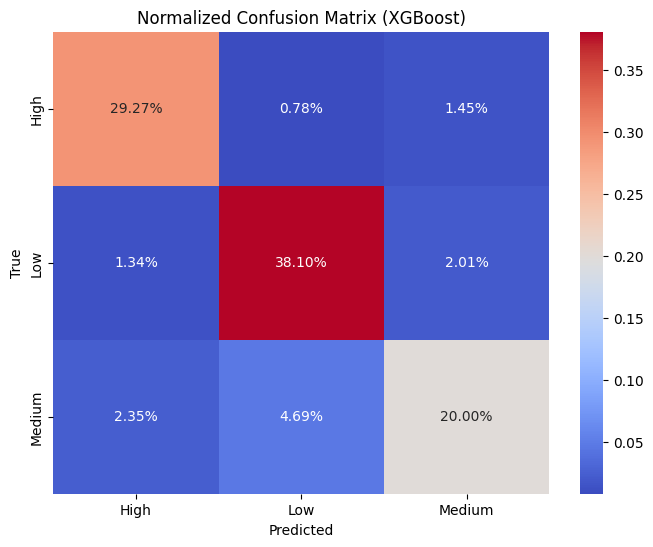

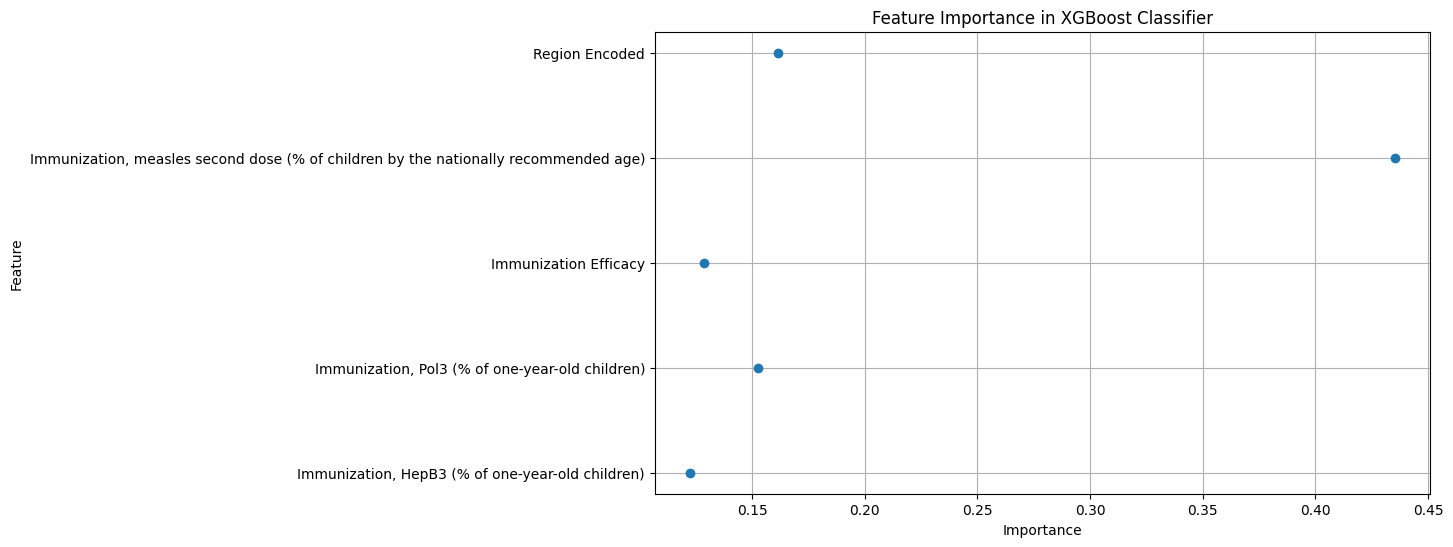

('              precision    recall  f1-score   support\n\n        High       0.89      0.93      0.91       282\n         Low       0.87      0.92      0.90       371\n      Medium       0.85      0.74      0.79       242\n\n    accuracy                           0.87       895\n   macro avg       0.87      0.86      0.87       895\nweighted avg       0.87      0.87      0.87       895\n',
 array([[262,   7,  13],
        [ 12, 341,  18],
        [ 21,  42, 179]]),
 {'Accuracy': 0.8737430167597765,
  'Precision': np.float64(0.8727571030743079),
  'Recall': np.float64(0.8737430167597765),
  'F1 Score': np.float64(0.871794215042637)})

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

required_columns = [
    "Immunization, HepB3 (% of one-year-old children)",
    "Immunization, Pol3 (% of one-year-old children)",
    "Immunization Efficacy",
    "Immunization, measles second dose (% of children by the nationally recommended age)",
    "Mortality rate, infant (per 1,000 live births)"
]
Data_Set = pd.read_csv("/Users/sharanya/Downloads/phase3.csv")
Selected = Data_Set[required_columns].dropna()
import warnings
warnings.filterwarnings("ignore")


required_columns = [
    "Immunization, HepB3 (% of one-year-old children)",
    "Immunization, Pol3 (% of one-year-old children)",
    "Immunization Efficacy",
    "Immunization, measles second dose (% of children by the nationally recommended age)",
    "Mortality rate, infant (per 1,000 live births)"
]
Selected = Data_Set[required_columns].dropna()
bins = [0, 15, 30, Selected["Mortality rate, infant (per 1,000 live births)"].max()]
labels = ['Low', 'Medium', 'High']
Selected["Mortality Rate Category"] = pd.cut(Selected["Mortality rate, infant (per 1,000 live births)"], bins=bins, labels=labels)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(Selected["Mortality Rate Category"])

if "Region Name" in Data_Set.columns:
    Data_Set["Region Encoded"] = LabelEncoder().fit_transform(Data_Set["Region Name"])
    Selected["Region Encoded"] = Data_Set["Region Encoded"]

X = Selected.drop(columns=["Mortality rate, infant (per 1,000 live births)", "Mortality Rate Category"])
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, random_state=35)
xgb_model = xgb.XGBClassifier(learning_rate=0.1, max_depth=6, n_estimators=100, use_label_encoder=False, eval_metric="mlogloss", random_state=35)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
Accuracy = accuracy_score(y_test, y_pred)
Precision = precision_score(y_test, y_pred, average='weighted')
Recall = recall_score(y_test, y_pred, average='weighted')
F1_Score = f1_score(y_test, y_pred, average='weighted')
Confusion_Matrix = confusion_matrix(y_test, y_pred)
Results = {
    'Accuracy': Accuracy,
    'Precision': Precision,
    'Recall': Recall,
    'F1 Score': F1_Score
}

print(Results)
plt.figure(figsize=(8, 6))
sns.heatmap(Confusion_Matrix / np.sum(Confusion_Matrix), annot=True, fmt='.2%', cmap='coolwarm', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix (XGBoost)")
plt.show()

Feature_Importances = xgb_model.feature_importances_
x_features = X.columns
plt.figure(figsize=(10, 6))
plt.plot(Feature_Importances, x_features, 'o')
plt.title("Feature Importance in XGBoost Classifier")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.grid(True)
plt.show()

Classification_Report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
Classification_Report, Confusion_Matrix, Results

ML, MR, and/or statistical modeling algorithms:

For Question 2 & it's hypothesis, Decision Tree algorithm is implemented.
Question 2: How do different regions vary based on the infant mortality rates?

Hypothesis 1.Analysis Infant mortality rates in different regions based on various factors like low birth weights, number of infant deaths and still births to see where the mortality rates are high.

Hypothesis 2. Does the Lower birth weight have increased dependecy on Mortality artes of specific region?

The code related to Question 2 & it's respective hypothesis is given below.

Dcision Tree classifier
Accuracy 0.8932135728542914
Precision 0.9102030066850426
Recall 0.8932135728542914
F1 Score 0.8896647093855617

Classification Report:
                                                       precision    recall  f1-score   support

                                         Afghanistan       1.00      1.00      1.00         5
                         Africa Eastern and Southern       1.00      0.20      0.33         5
                          Africa Western and Central       0.67      1.00      0.80         8
                                             Albania       1.00      0.86      0.92         7
                                             Algeria       0.80      1.00      0.89         4
                                              Angola       1.00      1.00      1.00         5
                                 Antigua and Barbuda       1.00      1.00      1.00         3
                                          Arab World       1.00      1.00      1.00    

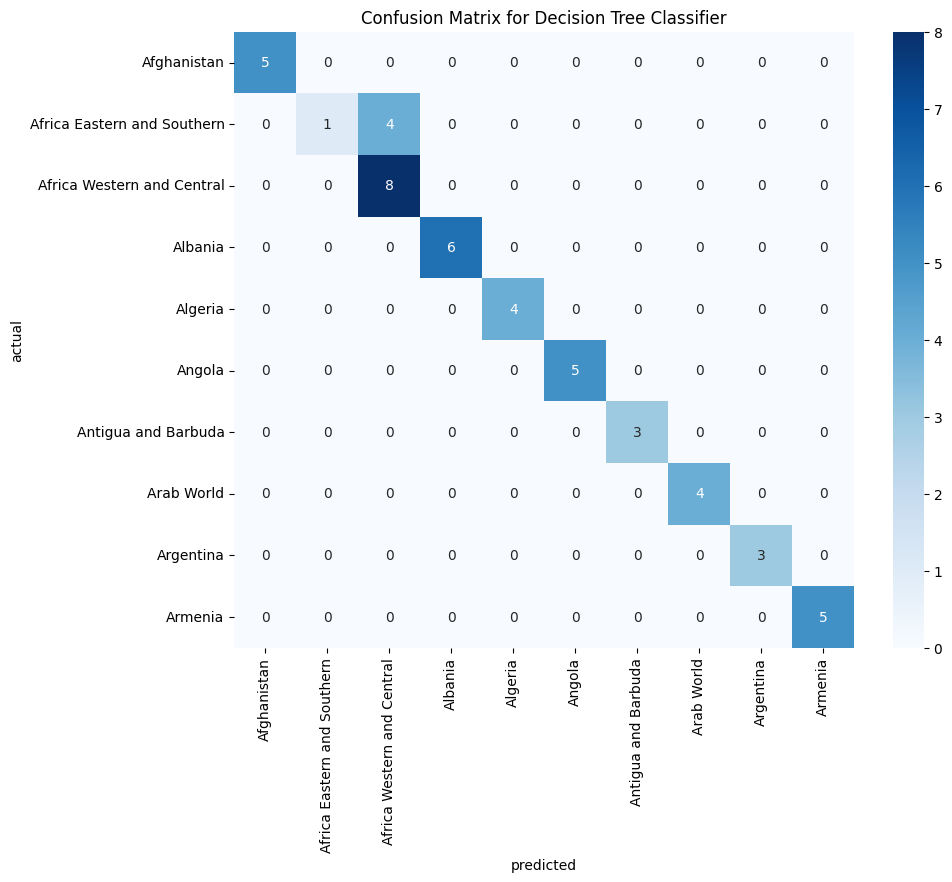

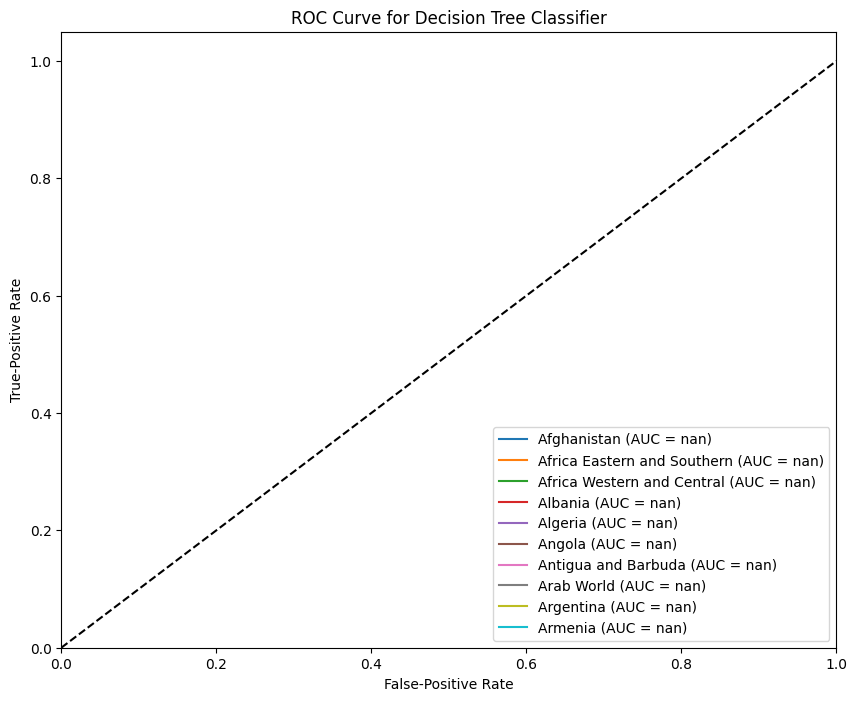

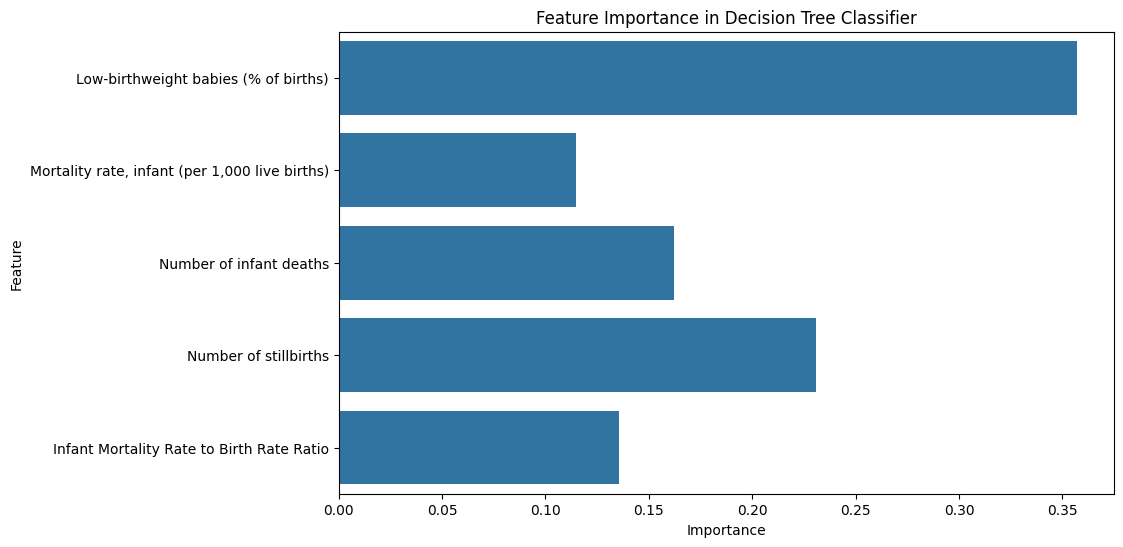

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier

Data_Set = pd.read_csv("/Users/sharanya/Downloads/phase3.csv")

Required_columns = [
    'Low-birthweight babies (% of births)',
    'Mortality rate, infant (per 1,000 live births)',
    'Number of infant deaths',
    'Number of stillbirths',
    'Infant Mortality Rate to Birth Rate Ratio',
    'Region Name'
]

Data_Selected = Data_Set[Required_columns].dropna()

X = Data_Selected.drop(columns=["Region Name"])
y = Data_Selected["Region Name"]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.28, random_state=42)

Dtree_classifier = DecisionTreeClassifier(random_state=42)
Dtree_classifier.fit(X_train, y_train)

y_pred_dt = Dtree_classifier.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt, average='weighted', zero_division=0)
recall_dt = recall_score(y_test, y_pred_dt, average='weighted', zero_division=0)
f1_dt = f1_score(y_test, y_pred_dt, average='weighted')
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
class_report_dt = classification_report(y_test, y_pred_dt, target_names=label_encoder.classes_)

print("Dcision Tree classifier")
print("Accuracy", accuracy_dt)
print("Precision", precision_dt)
print("Recall", recall_dt)
print("F1 Score", f1_dt)
print("\nClassification Report:\n", class_report_dt)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_dt[:10, :10], annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_[:10], yticklabels=label_encoder.classes_[:10])
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('Confusion Matrix for Decision Tree Classifier')
plt.show()

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

y_test_binarized = label_binarize(y_test, classes=label_encoder.classes_)
y_pred_binarized = label_binarize(y_pred_dt, classes=label_encoder.classes_)

plt.figure(figsize=(10, 8))
for i in range(len(label_encoder.classes_[:10])):  # Limiting to first 10 classes for clarity
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{label_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False-Positive Rate')
plt.ylabel('True-Positive Rate')
plt.title('ROC Curve for Decision Tree Classifier')
plt.legend(loc="lower right")
plt.show()

dtree_classifier = DecisionTreeClassifier(max_depth=10, max_features= "sqrt", random_state=42)
dtree_classifier.fit(X_train, y_train)
if hasattr(dtree_classifier, "feature_importances_"):
    feature_importances = dtree_classifier.feature_importances_
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importances, y=X.columns)
    plt.title('Feature Importance in Decision Tree Classifier')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

Student Name: Sharanya Nallapeddi
Student ID: 50593866
Mail ID: snallape@buffalo.edu

Exploratory Data Analysis(EDA)

The questions & hypothesis taken into account for the EDA are listed below:

Question 1: Is there a correlation between the prevalence of anemia in children & the number of child deaths? 

Hypothesis:
1. The likelihood of child mortality increases with the prevalence of anemia in children
2. The correlation between infant anemia prevalence & infant mortality is substantially lower in areas with high levels of socioeconomic development & maternal education.

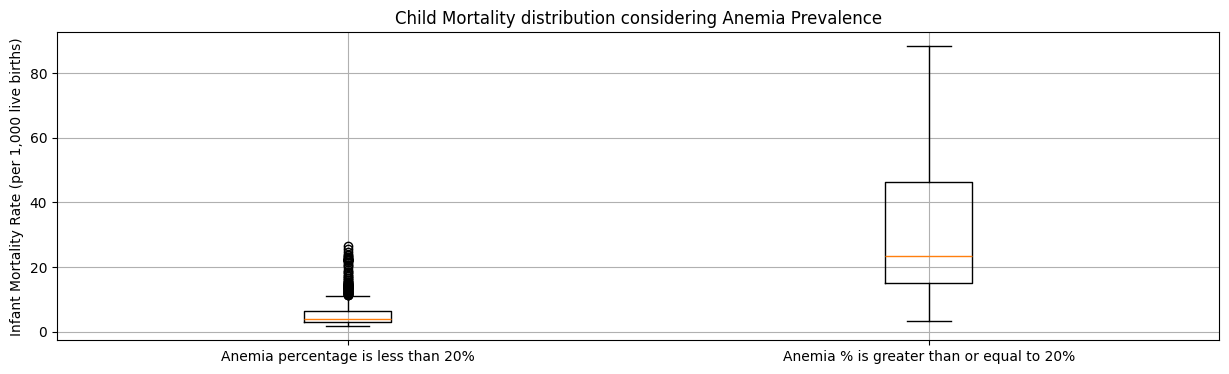

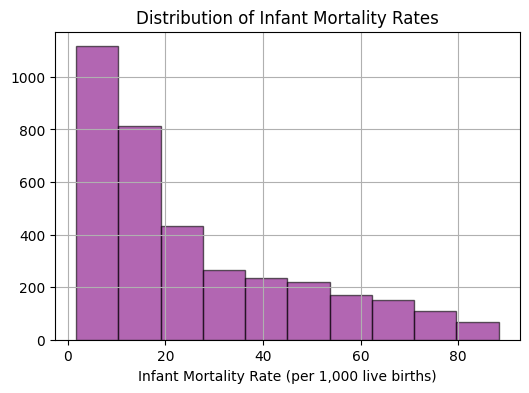

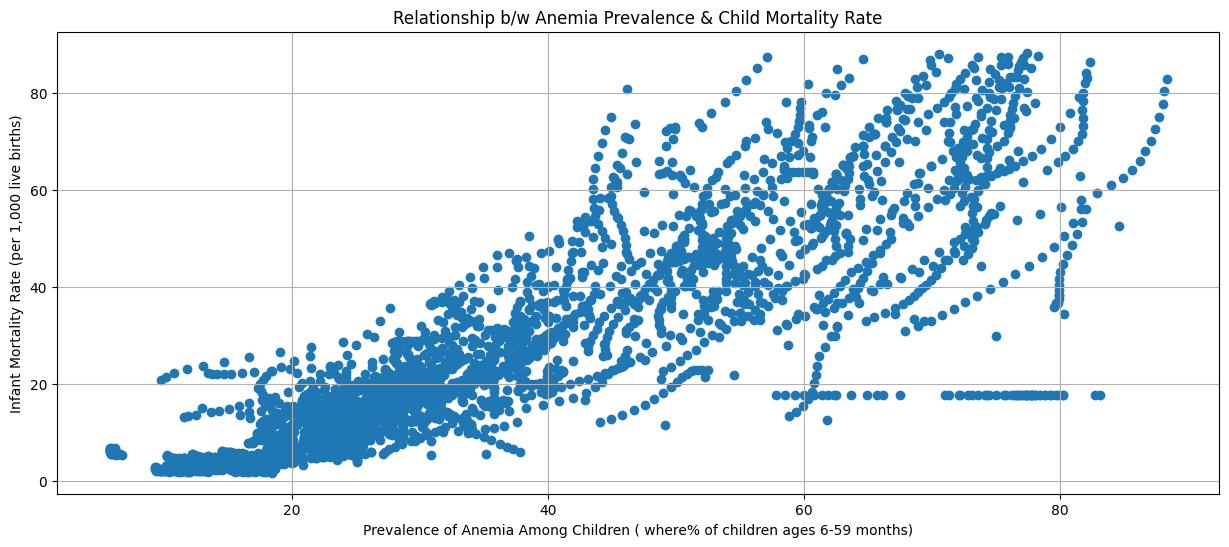

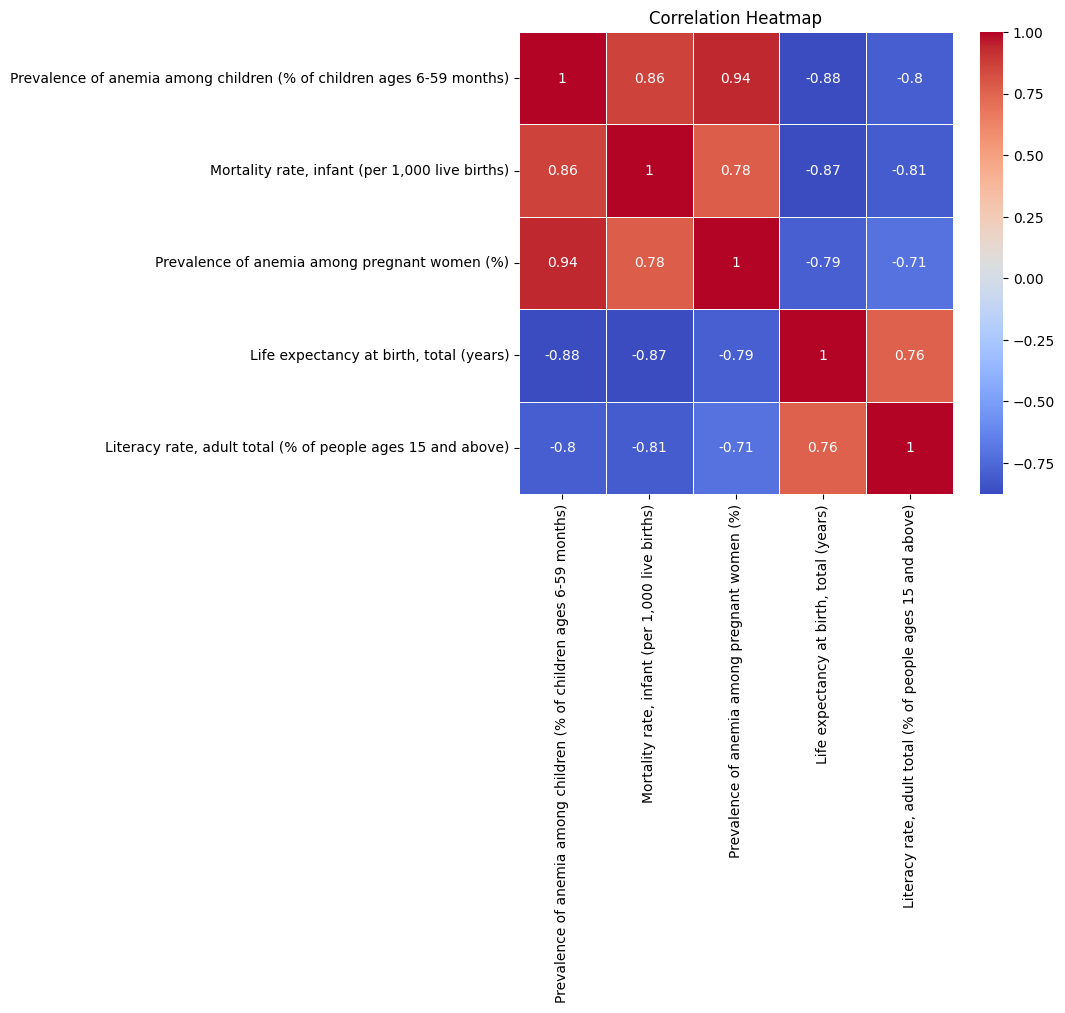

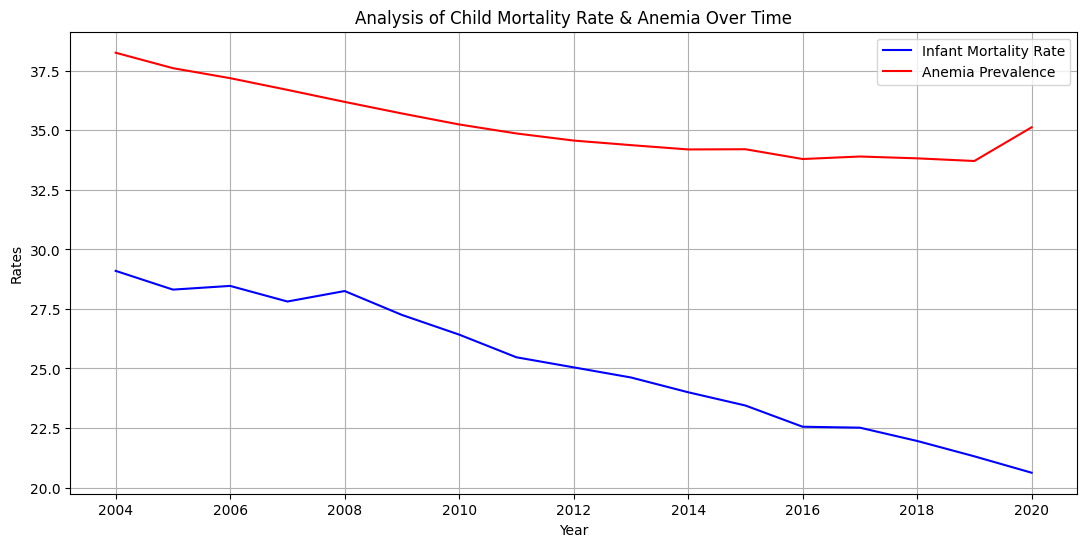

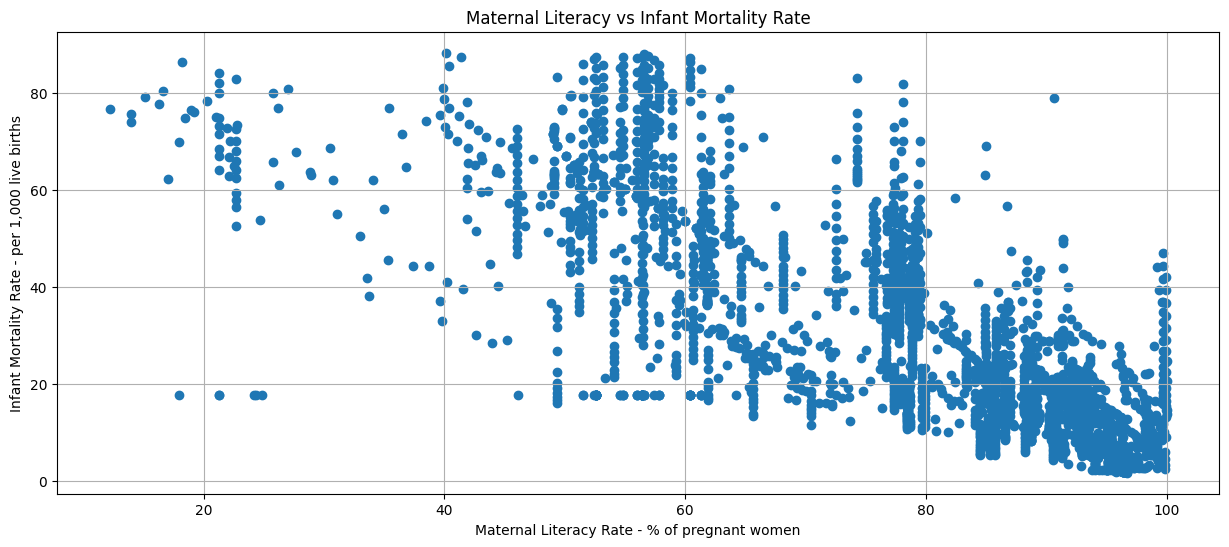

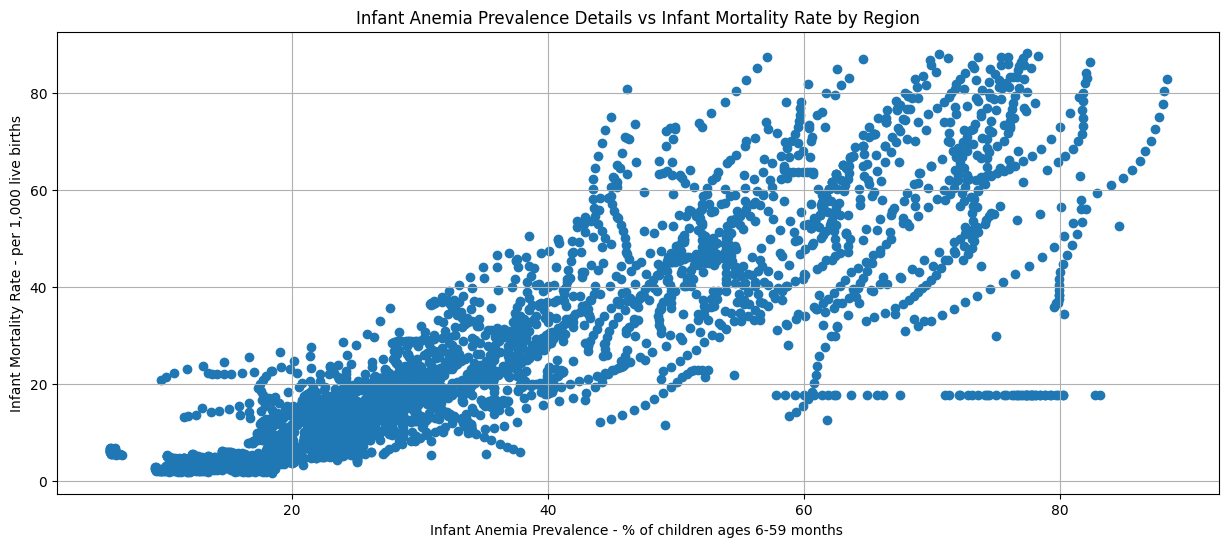

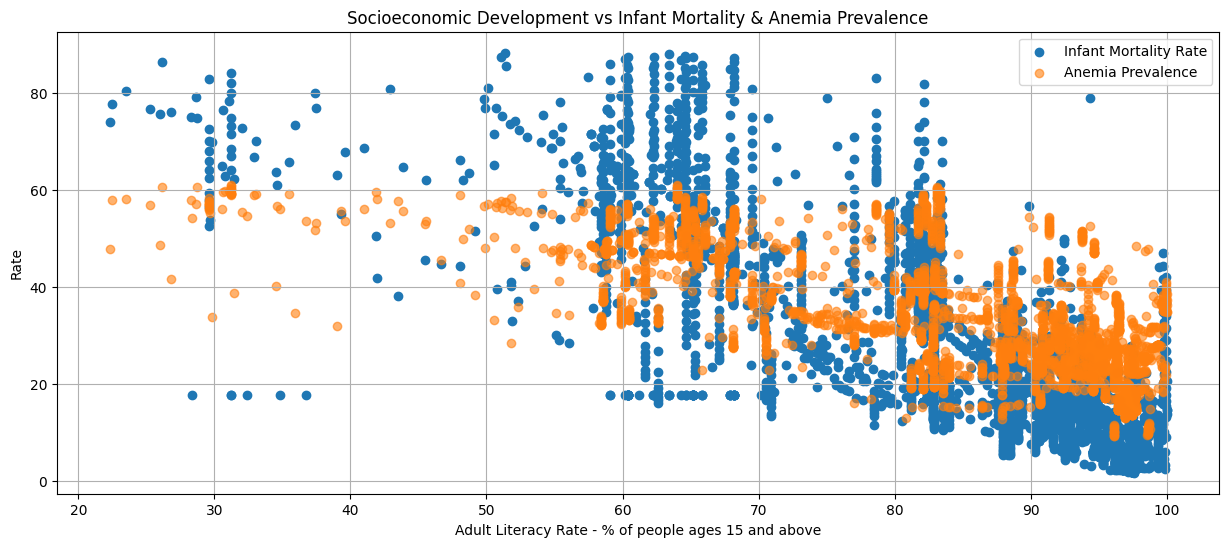

In [9]:
import pandas as pd
import os
import matplotlib.pyplot as plot
import seaborn as sns

file_path = '/Users/sharanya/Downloads/phase3.csv' 

#Load the file from Local folder
hypothesis_ds = pd.read_csv(file_path)
#Question 1
#Hypothesis 1 - Plot 1

plot.figure(figsize=(15,4))
plot.boxplot([hypothesis_ds['Mortality rate, infant (per 1,000 live births)'][hypothesis_ds['Prevalence of anemia among children (% of children ages 6-59 months)'] < 20],
             hypothesis_ds['Mortality rate, infant (per 1,000 live births)'][hypothesis_ds['Prevalence of anemia among children (% of children ages 6-59 months)'] >= 20]],
            tick_labels=['Anemia percentage is less than 20%', 'Anemia % is greater than or equal to 20%'])
plot.title('Child Mortality distribution considering Anemia Prevalence')
plot.ylabel('Infant Mortality Rate (per 1,000 live births)')
plot.grid(True)
plot.show()

#Question 1
#Hypothesis 1 - Plot 2(Different kinds)

#Plot to explain 'Distribution of Infant Mortality Rates'
plot.figure(figsize=(6,4))
plot.hist(hypothesis_ds['Mortality rate, infant (per 1,000 live births)'], bins=10, alpha=0.6, color='purple', edgecolor='black')
plot.title('Distribution of Infant Mortality Rates')
plot.xlabel('Infant Mortality Rate (per 1,000 live births)')
plot.grid(True)
plot.show()

#Plot to explain 'Relationship b/w Anemia Prevalence & Child Mortality Rate' 
plot.figure(figsize=(15, 6))
plot.scatter(hypothesis_ds['Prevalence of anemia among children (% of children ages 6-59 months)'], hypothesis_ds['Mortality rate, infant (per 1,000 live births)'])
plot.title('Relationship b/w Anemia Prevalence & Child Mortality Rate')
plot.xlabel('Prevalence of Anemia Among Children ( where% of children ages 6-59 months)')
plot.ylabel('Infant Mortality Rate (per 1,000 live births)')
plot.grid(True)
plot.show()

# Plot to explain Heatmap(correlation between multiple factors
plot.figure(figsize=(7, 6))
correlation_matrix = hypothesis_ds[['Prevalence of anemia among children (% of children ages 6-59 months)', 
                         'Mortality rate, infant (per 1,000 live births)', 
                         'Prevalence of anemia among pregnant women (%)', 
                         'Life expectancy at birth, total (years)', 
                         'Literacy rate, adult total (% of people ages 15 and above)']].corr()

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plot.title('Correlation Heatmap')
plot.show()

# Using Year column for analysis - Analysis of Child Mortality Rate & Anemia Over Time
if 'Year' in hypothesis_ds.columns:
    
    # Check - Year' is in numeric format
    if pd.api.types.is_numeric_dtype(hypothesis_ds['Year']):
        # Use 'Year' directly without conversion
        hypothesis_ds['Year'] = hypothesis_ds['Year']
    else:
        hypothesis_ds['Year'] = pd.to_datetime(hypothesis_ds['Year']).dt.year

    plot.figure(figsize=(13, 6))
    
    plot.plot(hypothesis_ds.groupby('Year')['Mortality rate, infant (per 1,000 live births)'].mean(), 
             label='Infant Mortality Rate', color='blue')

    plot.plot(hypothesis_ds.groupby('Year')['Prevalence of anemia among children (% of children ages 6-59 months)'].mean(), 
             label='Anemia Prevalence', color='red')
    
    plot.title('Analysis of Child Mortality Rate & Anemia Over Time')
    plot.xlabel('Year')
    plot.ylabel('Rates')
    plot.legend()
    plot.grid(True)
    plot.show()

else:
    print("The 'Year' column is not available.")

#Question 1
#Hypothesis 2 
#Plot 1, 2 & 3


# Plot 1: Correlation between maternal literacy & infant mortality rate
plot.figure(figsize=(15, 6))
plot.scatter(hypothesis_ds['Literacy rate, Pregnant Women (% of pregnant women ages 15 and above)'], hypothesis_ds['Mortality rate, infant (per 1,000 live births)'])
plot.title('Maternal Literacy vs Infant Mortality Rate')
plot.xlabel('Maternal Literacy Rate - % of pregnant women')
plot.ylabel('Infant Mortality Rate - per 1,000 live births')
plot.grid(True)
plot.show()

# Plot 2: Infant anemia prevalence Details vs infant mortality rate by regions
plot.figure(figsize=(15, 6))
plot.scatter(hypothesis_ds['Prevalence of anemia among children (% of children ages 6-59 months)'], hypothesis_ds['Mortality rate, infant (per 1,000 live births)'])
plot.title('Infant Anemia Prevalence Details vs Infant Mortality Rate by Region')
plot.xlabel('Infant Anemia Prevalence - % of children ages 6-59 months ')
plot.ylabel('Infant Mortality Rate - per 1,000 live births')
plot.grid(True)
plot.show()

# Plot 3: Socioeconomic development [maternal literacy & healthcare access] vs infant mortality rate
plot.figure(figsize=(15, 6))
plot.scatter(hypothesis_ds['Literacy rate, adult total (% of people ages 15 and above)'], hypothesis_ds['Mortality rate, infant (per 1,000 live births)'], label='Infant Mortality Rate')
plot.scatter(hypothesis_ds['Literacy rate, adult total (% of people ages 15 and above)'], hypothesis_ds['Prevalence of anemia among pregnant women (%)'], label='Anemia Prevalence', alpha=0.6)
plot.title('Socioeconomic Development vs Infant Mortality & Anemia Prevalence')
plot.xlabel('Adult Literacy Rate - % of people ages 15 and above')
plot.ylabel('Rate')
plot.legend()
plot.grid(True)
plot.show()


Exploratory Data Analysis(EDA)

The questions & hypothesis taken into account for the EDA are listed below:

Question 2. How does maternal hypertension correlate with low birthweight & infant mortality?

Hypothesis:
1. Increased maternal hypertension is strongly related with higher rates of low birthweight & infant mortality rates.
2. Exposure to maternal healthcare services serves as a mediating factor in the correlation between low birthweight/infant mortality & maternal hypertension.

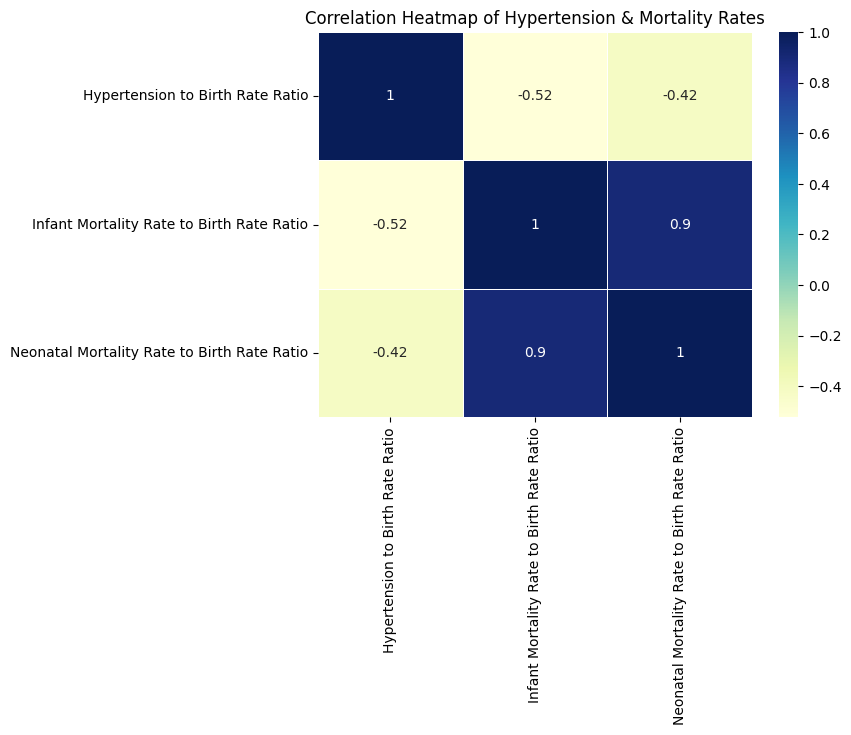

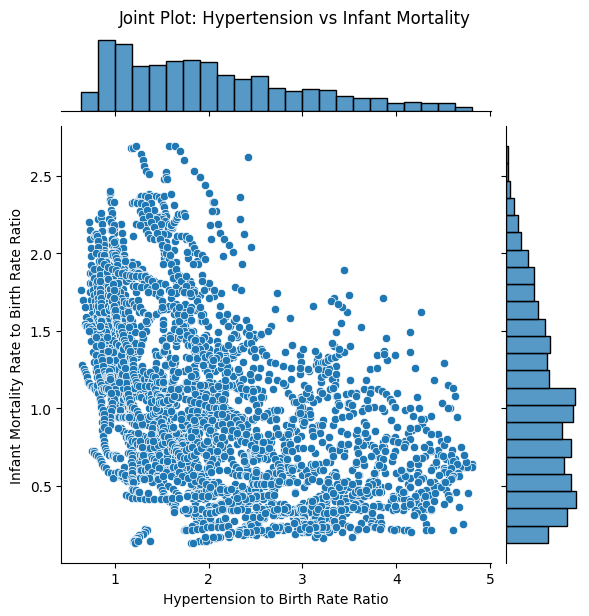

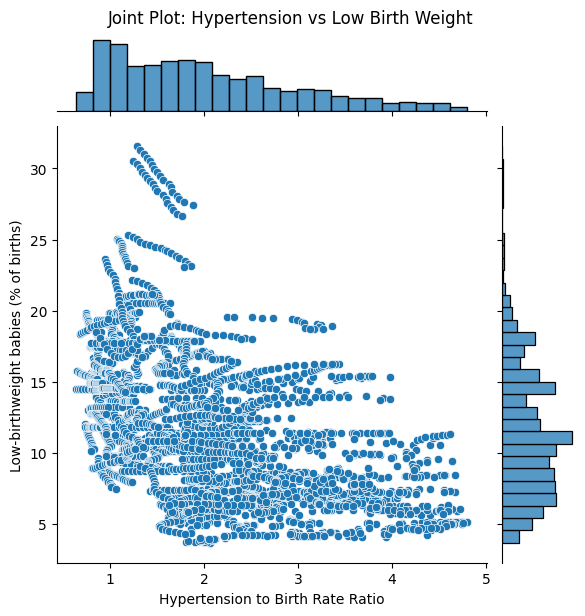

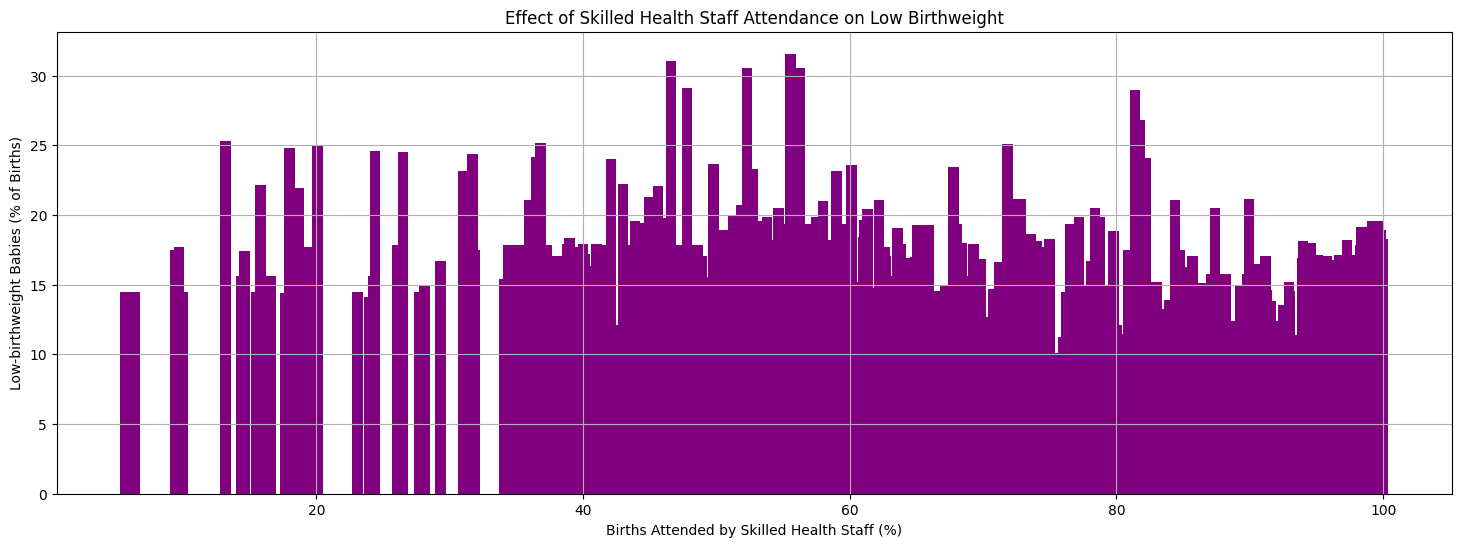

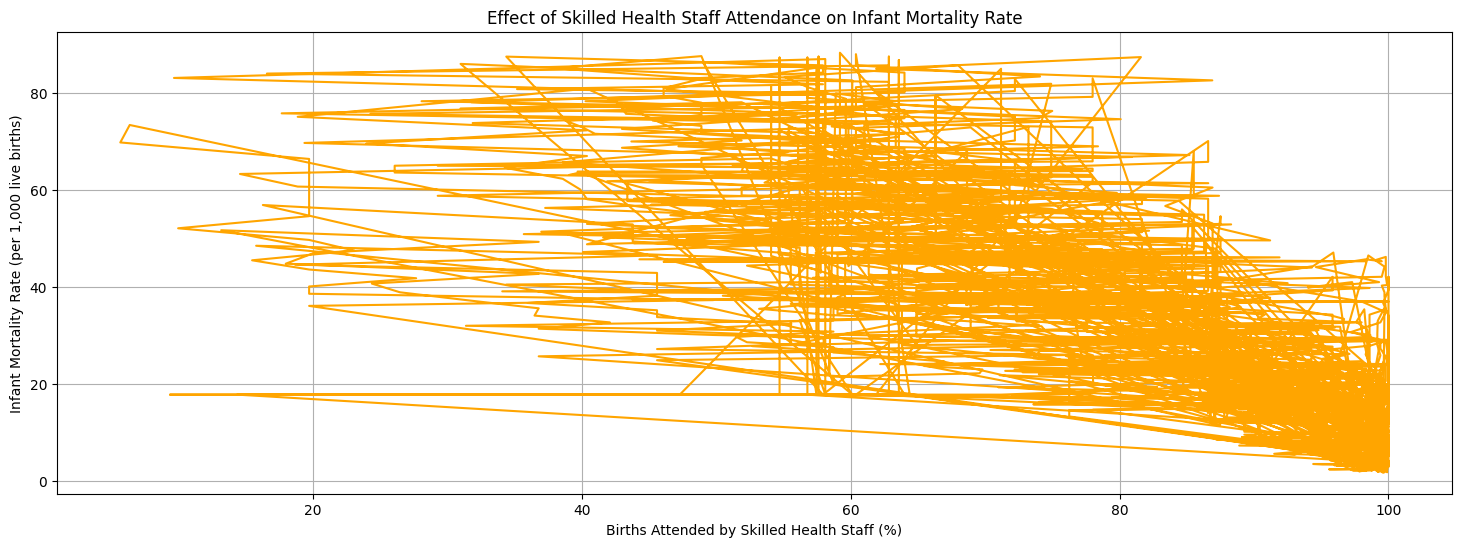

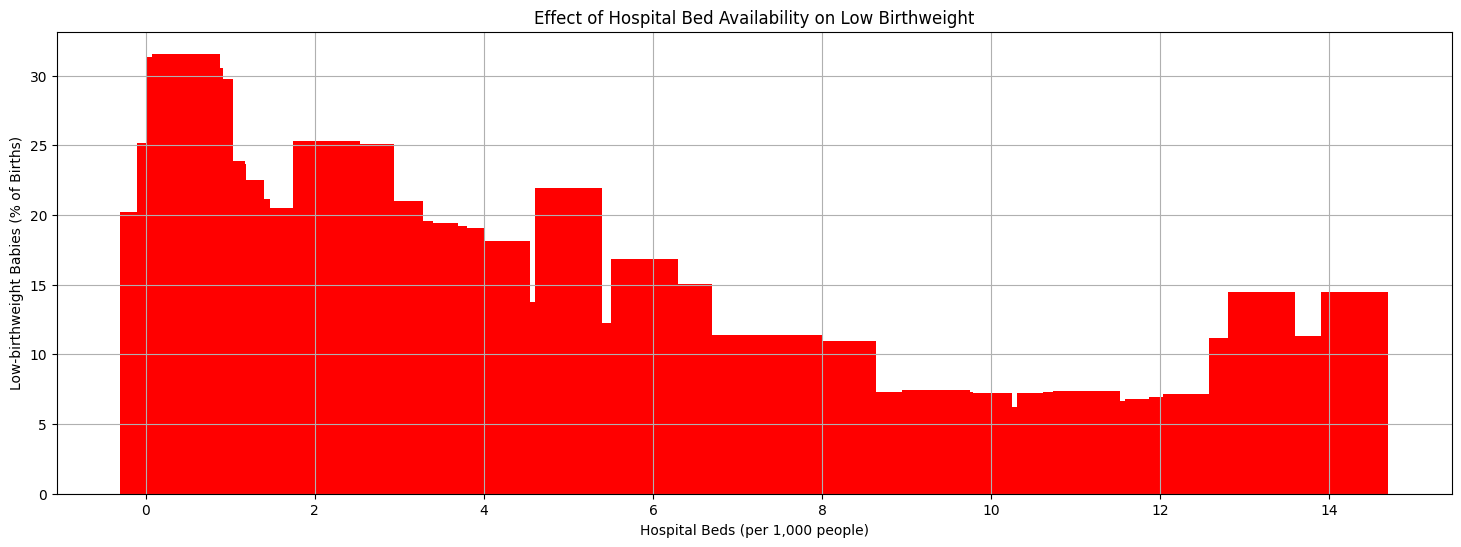

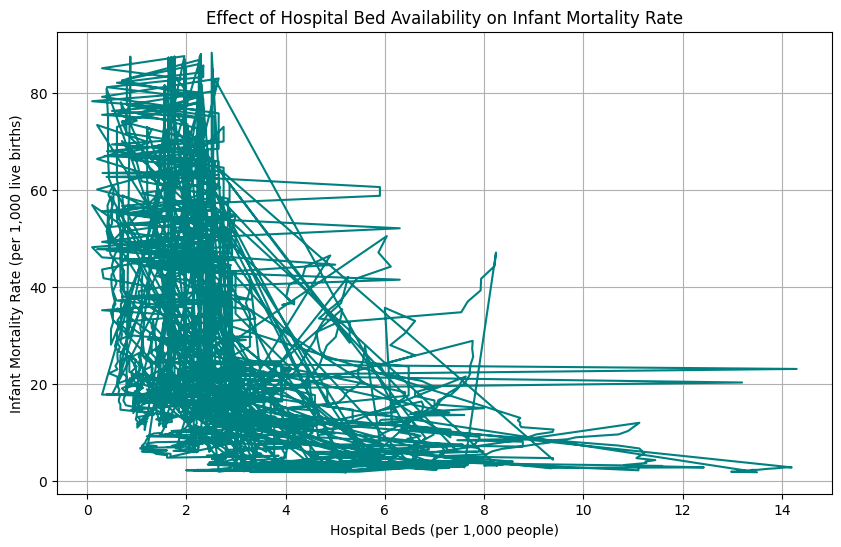

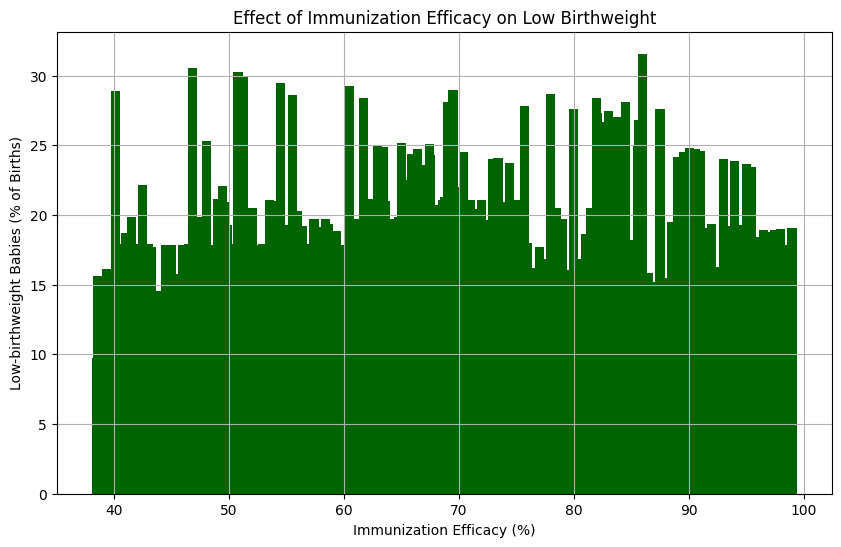

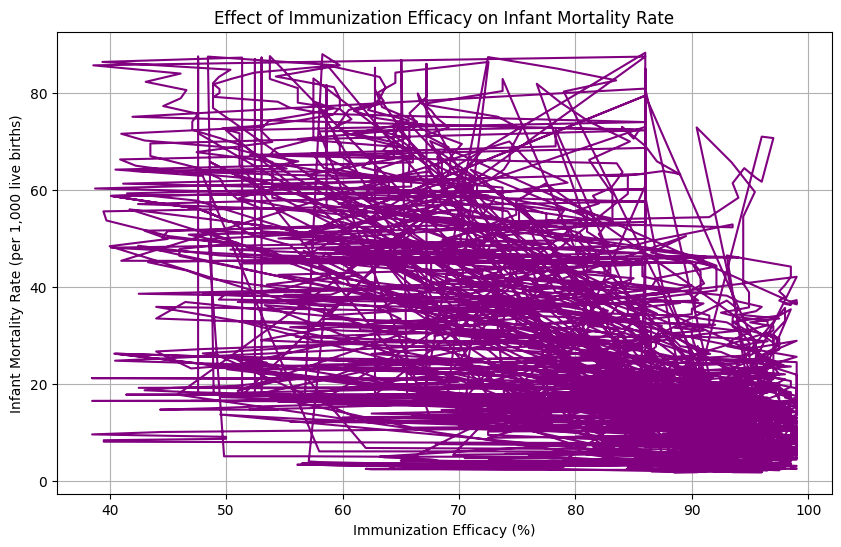

<Figure size 700x600 with 0 Axes>

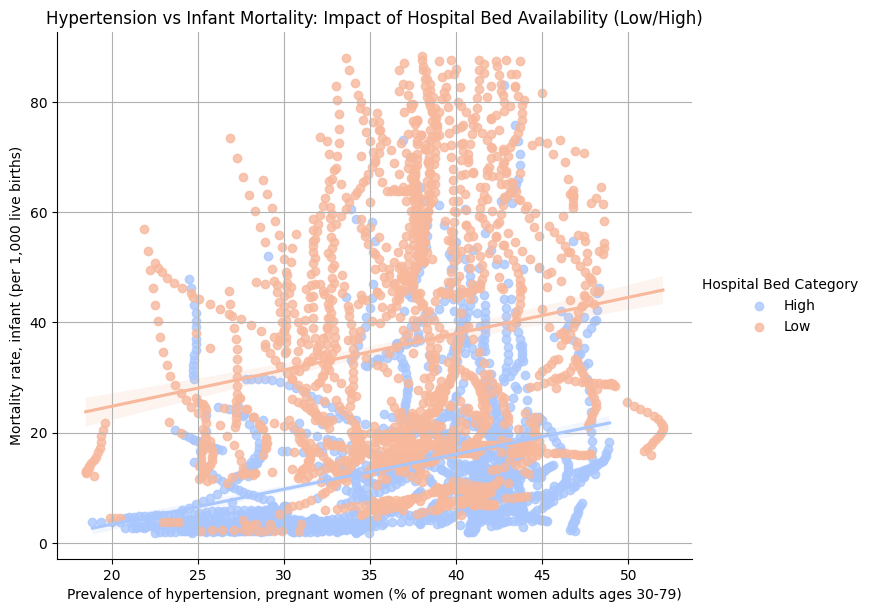

<Figure size 700x600 with 0 Axes>

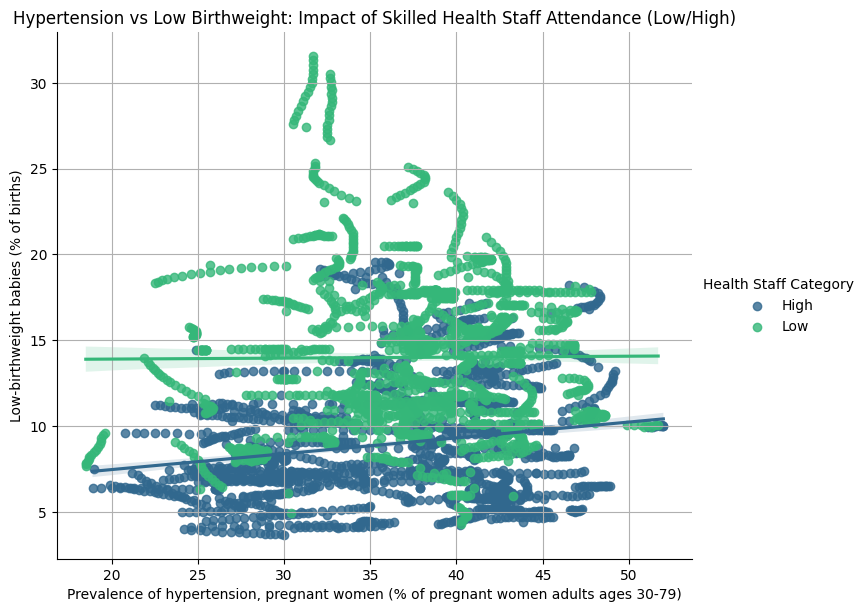

In [10]:
#Question 2
#Hypothesis 1
# Plot 1: Heatmap to show the correlation between maternal hypertension & mortality rates.
import seaborn as sns

plot.figure(figsize=(7, 5))
correlation_data = hypothesis_ds[['Hypertension to Birth Rate Ratio', 
                             'Infant Mortality Rate to Birth Rate Ratio',
                             'Neonatal Mortality Rate to Birth Rate Ratio']].corr()

sns.heatmap(correlation_data, annot=True, cmap='YlGnBu', linewidths=0.5)
plot.title('Correlation Heatmap of Hypertension & Mortality Rates')
plot.show()

#Question 2
#Hypothesis 1
#Plot 2
import seaborn as sns
import matplotlib.pyplot as plot

sns.jointplot(x='Hypertension to Birth Rate Ratio', 
              y='Infant Mortality Rate to Birth Rate Ratio', 
              data=hypothesis_ds, 
              kind='scatter')
plot.suptitle('Joint Plot: Hypertension vs Infant Mortality', y=1.02)
plot.show()

sns.jointplot(x='Hypertension to Birth Rate Ratio', 
              y='Low-birthweight babies (% of births)', 
              data=hypothesis_ds, 
              kind='scatter')
plot.suptitle('Joint Plot: Hypertension vs Low Birth Weight', y=1.02)
plot.show()

#Question 2
#Hypothesis 2
#First Plot(Different kinds)

# Graph 1: Bar plot for Skilled Health Staff Attendance vs Low Birthweight
plot.figure(figsize=(18, 6))
plot.bar(hypothesis_ds['Births attended by skilled health staff (% of total)'], 
        hypothesis_ds['Low-birthweight babies (% of births)'], color='purple')
plot.title('Effect of Skilled Health Staff Attendance on Low Birthweight')
plot.xlabel('Births Attended by Skilled Health Staff (%)')
plot.ylabel('Low-birthweight Babies (% of Births)')
plot.grid(True)
plot.show()

# Graph 2: Line plot for Skilled Health Staff Attendance vs Infant Mortality Rate
plot.figure(figsize=(18, 6))
plot.plot(hypothesis_ds['Births attended by skilled health staff (% of total)'], 
         hypothesis_ds['Mortality rate, infant (per 1,000 live births)'], color='orange')
plot.title('Effect of Skilled Health Staff Attendance on Infant Mortality Rate')
plot.xlabel('Births Attended by Skilled Health Staff (%)')
plot.ylabel('Infant Mortality Rate (per 1,000 live births)')
plot.grid(True)
plot.show()

# Graph 3: Bar plot for Hospital Beds vs Low Birthweight
plot.figure(figsize=(18, 6))
plot.bar(hypothesis_ds['Hospital beds (per 1,000 people)'], 
        hypothesis_ds['Low-birthweight babies (% of births)'], color='red')
plot.title('Effect of Hospital Bed Availability on Low Birthweight')
plot.xlabel('Hospital Beds (per 1,000 people)')
plot.ylabel('Low-birthweight Babies (% of Births)')
plot.grid(True)
plot.show()

# Graph 4: Line plot for Hospital Beds vs Infant Mortality Rate
plot.figure(figsize=(10, 6))
plot.plot(hypothesis_ds['Hospital beds (per 1,000 people)'], 
         hypothesis_ds['Mortality rate, infant (per 1,000 live births)'], color='teal')
plot.title('Effect of Hospital Bed Availability on Infant Mortality Rate')
plot.xlabel('Hospital Beds (per 1,000 people)')
plot.ylabel('Infant Mortality Rate (per 1,000 live births)')
plot.grid(True)
plot.show()

# Graph 5: Bar plot for Immunization Efficacy vs Low Birthweight
plot.figure(figsize=(10, 6))
plot.bar(hypothesis_ds['Immunization Efficacy'], 
        hypothesis_ds['Low-birthweight babies (% of births)'], color='darkgreen')
plot.title('Effect of Immunization Efficacy on Low Birthweight')
plot.xlabel('Immunization Efficacy (%)')
plot.ylabel('Low-birthweight Babies (% of Births)')
plot.grid(True)
plot.show()

# Graph 6: Line plot for Immunization Efficacy vs Infant Mortality Rate
plot.figure(figsize=(10, 6))
plot.plot(hypothesis_ds['Immunization Efficacy'], 
         hypothesis_ds['Mortality rate, infant (per 1,000 live births)'], color='purple')
plot.title('Effect of Immunization Efficacy on Infant Mortality Rate')
plot.xlabel('Immunization Efficacy (%)')
plot.ylabel('Infant Mortality Rate (per 1,000 live births)')
plot.grid(True)
plot.show()

#Question 2
#Hypothesis 2

#Second Plot(Different Kinds)
# Manually define thresholds for low/high categories
threshold_hospital_beds = hypothesis_ds['Hospital beds (per 1,000 people)'].median()
hypothesis_ds['Hospital Bed Category'] = np.where(hypothesis_ds['Hospital beds (per 1,000 people)'] > threshold_hospital_beds, 'High', 'Low')

threshold_health_staff = hypothesis_ds['Births attended by skilled health staff (% of total)'].median()
hypothesis_ds['Health Staff Category'] = np.where(hypothesis_ds['Births attended by skilled health staff (% of total)'] > threshold_health_staff, 'High', 'Low')

# Regression plot for hypertension vs infant mortality, grouped by hospital bed availability
plot.figure(figsize=(7, 6))
sns.lmplot(x='Prevalence of hypertension, pregnant women (% of pregnant women adults ages 30-79)', 
           y='Mortality rate, infant (per 1,000 live births)', 
           hue='Hospital Bed Category', data=hypothesis_ds, palette='coolwarm', height=6, aspect=1.2)
plot.title("Hypertension vs Infant Mortality: Impact of Hospital Bed Availability (Low/High)")
plot.grid(True)
plot.show()

# Regression plot for hypertension vs low birthweight, grouped by skilled health staff attendance 
plot.figure(figsize=(7, 6))
sns.lmplot(x='Prevalence of hypertension, pregnant women (% of pregnant women adults ages 30-79)', 
           y='Low-birthweight babies (% of births)', 
           hue='Health Staff Category', data=hypothesis_ds, palette='viridis', height=6, aspect=1.2)
plot.title("Hypertension vs Low Birthweight: Impact of Skilled Health Staff Attendance (Low/High)")
plot.grid(True)
plot.show()

ML, MR, and/or statistical modeling algorithms:

We used algorithms like Support Vector Machines (SVMs) and Logistic Regression in our investigation to generate informative visualizations that clearly demonstrate the answers to the following problems & it's respective hypothesis.

Problem 1. Is there a correlation between the prevalence of anemia in children & the number of child deaths?

Hypothesis 1. The likelihood of child mortality increases with the prevalence of anemia in children.
Hypothesis 2. The correlation between infant anemia prevalence & infant mortality is substantially lower in areas with high levels of socioeconomic development & maternal education.

Note: For the sake of clarity and a better understanding of algorithms, both SVM and logistic regression were used in order to compare the accuracy and other evaluation metrics. But, the primary algorithm to be considered for Problem 1 is Logistic Regression.

0.9962756052141527
[[552   2]
 [  2 518]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       554
           1       1.00      1.00      1.00       520

    accuracy                           1.00      1074
   macro avg       1.00      1.00      1.00      1074
weighted avg       1.00      1.00      1.00      1074

0.9962756052141527
[[553   1]
 [  3 517]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       554
           1       1.00      0.99      1.00       520

    accuracy                           1.00      1074
   macro avg       1.00      1.00      1.00      1074
weighted avg       1.00      1.00      1.00      1074



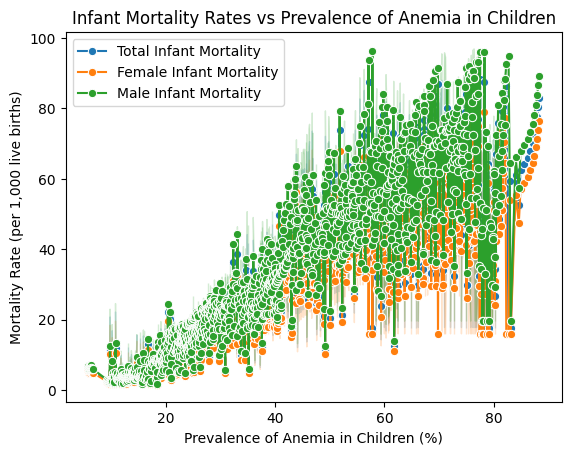

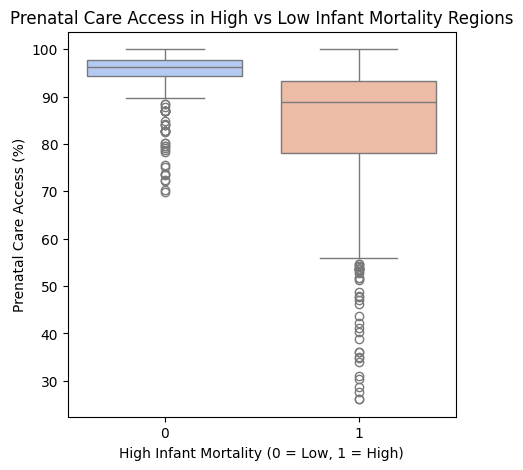

In [11]:
#Logistic Regression
#Problem 1 & Hypothesis 1 & 2
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plot
import warnings
warnings.filterwarnings('ignore')

file_path = '/Users/sharanya/Downloads/phase3.csv' 

dataset_cleaned2 = pd.read_csv(file_path)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

hypothesis_1_data = dataset_cleaned2[['Mortality rate, infant (per 1,000 live births)',
                          'Mortality rate, infant, female (per 1,000 live births)',
                          'Mortality rate, infant, male (per 1,000 live births)',
                          'Prevalence of anemia among children (% of children ages 6-59 months)']]

hypothesis_2_data = dataset_cleaned2[['Prevalence of anemia among children (% of children ages 6-59 months)',
                          'Mortality rate, infant (per 1,000 live births)',
                          'Mortality rate, infant, female (per 1,000 live births)',
                          'Mortality rate, infant, male (per 1,000 live births)',
                          'Pregnant women receiving prenatal care (%)',
                          'Literacy rate, Pregnant Women (% of pregnant women ages 15 and above)',
                          'Hospital beds (per 1,000 people)',
                          'Physicians (per 1,000 people)']]

# Dropping rows with missing values to ensure integrity of the model - Model tuning & processing
hypothesis_1_data = hypothesis_1_data.dropna()
hypothesis_2_data = hypothesis_2_data.dropna()

# Define a  target variable for hypothesis 1: classify  high vs low infant mortality based on the generated median
threshold_h1 = hypothesis_1_data['Mortality rate, infant (per 1,000 live births)'].median()
hypothesis_1_data['High_Infant_Mortality'] = (hypothesis_1_data['Mortality rate, infant (per 1,000 live births)'] >= threshold_h1).astype(int)

# Features & target split for Hypothesis 1
X1 = hypothesis_1_data[['Mortality rate, infant, female (per 1,000 live births)', 
                        'Mortality rate, infant, male (per 1,000 live births)', 
                        'Prevalence of anemia among children (% of children ages 6-59 months)']]
y1 = hypothesis_1_data['High_Infant_Mortality']

# Logistic Regression Algorithm implementation for Hypothesis 1
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)
log_reg1 = LogisticRegression()
log_reg1.fit(X1_train, y1_train)
y1_pred = log_reg1.predict(X1_test)
accuracy1 = accuracy_score(y1_test, y1_pred)
conf_matrix1 = confusion_matrix(y1_test, y1_pred)
class_report1 = classification_report(y1_test, y1_pred)

print(accuracy1)
print(conf_matrix1)
print(class_report1)

# Define a target variable for hypothesis 2: classify as high vs low infant mortality based on median
threshold_h2 = hypothesis_2_data['Mortality rate, infant (per 1,000 live births)'].median()
hypothesis_2_data['High_Infant_Mortality'] = (hypothesis_2_data['Mortality rate, infant (per 1,000 live births)'] >= threshold_h2).astype(int)

# Features & target split for Hypothesis 2
X2 = hypothesis_2_data[['Prevalence of anemia among children (% of children ages 6-59 months)', 
                        'Mortality rate, infant, female (per 1,000 live births)', 
                        'Mortality rate, infant, male (per 1,000 live births)', 
                        'Pregnant women receiving prenatal care (%)', 
                        'Literacy rate, Pregnant Women (% of pregnant women ages 15 and above)', 
                        'Hospital beds (per 1,000 people)', 
                        'Physicians (per 1,000 people)']]
y2 = hypothesis_2_data['High_Infant_Mortality']

# Logistic Regression Algorithm implementation for Hypothesis 2
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)
log_reg2 = LogisticRegression()
log_reg2.fit(X2_train, y2_train)
y2_pred = log_reg2.predict(X2_test)
accuracy2 = accuracy_score(y2_test, y2_pred)
conf_matrix2 = confusion_matrix(y2_test, y2_pred)
class_report2 = classification_report(y2_test, y2_pred)

# Display evaluation metrics for Hypothesis 2
print(accuracy2)
print(conf_matrix2)
print(class_report2)

# Below are the visualizations using Logistic Regression algorithm for Hypotheses 1 and 2.
# Visualization 1: Line plot for Hypothesis 1
# Establishing the connection between infant mortality rates (both male and female) and the incidence of anemia
#This line plot illustrates the correlation between different newborn mortality rates (total, male, and female) and the incidence of anemia in children. 
#The trend supports the idea that the chance of child mortality increases with anemia prevalence by showing a correlation between higher anemia prevalence and higher infant mortality rates.
#(figsize=(10, 6)) plot.figure
sns.lineplot(x='Prevalence of anemia among children (% of children ages 6-59 months)', 
             y='Mortality rate, infant (per 1,000 live births)', 
             data=hypothesis_1_data, label='Total Infant Mortality', marker='o')
sns.lineplot(x='Prevalence of anemia among children (% of children ages 6-59 months)', 
             y='Mortality rate, infant, female (per 1,000 live births)', 
             data=hypothesis_1_data, label='Female Infant Mortality', marker='o')
sns.lineplot(x='Prevalence of anemia among children (% of children ages 6-59 months)', 
             y='Mortality rate, infant, male (per 1,000 live births)', 
             data=hypothesis_1_data, label='Male Infant Mortality', marker='o')
plot.title('Infant Mortality Rates vs Prevalence of Anemia in Children')
plot.xlabel('Prevalence of Anemia in Children (%)')
plot.ylabel('Mortality Rate (per 1,000 live births)')
plot.legend()
plot.show()

# Visualization 2: Box plot for Hypothesis 2
# Comparing the distribution of literacy and access to prenatal care in areas with high and low infant mortality
# Prenatal care access in areas with high and low infant mortality is contrasted in this box plot.
# The distribution shows that areas with higher access to prenatal care typically have lower baby mortality rates, indicating that healthcare access may have a moderating effect on the relationship between anemia and infant death.
hypothesis_2_data['High_Infant_Mortality'] = y2

plot.figure(figsize=(5,5))
sns.boxplot(x='High_Infant_Mortality', 
            y='Pregnant women receiving prenatal care (%)', 
            data=hypothesis_2_data, palette='coolwarm')
plot.title('Prenatal Care Access in High vs Low Infant Mortality Regions')
plot.xlabel('High Infant Mortality (0 = Low, 1 = High)')
plot.ylabel('Prenatal Care Access (%)')
plot.show()

0.9963666852990497
[[1775    5]
 [   8 1790]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1780
           1       1.00      1.00      1.00      1798

    accuracy                           1.00      3578
   macro avg       1.00      1.00      1.00      3578
weighted avg       1.00      1.00      1.00      3578

0.995248742314142
[[1776    4]
 [  13 1785]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1780
           1       1.00      0.99      1.00      1798

    accuracy                           1.00      3578
   macro avg       1.00      1.00      1.00      3578
weighted avg       1.00      1.00      1.00      3578



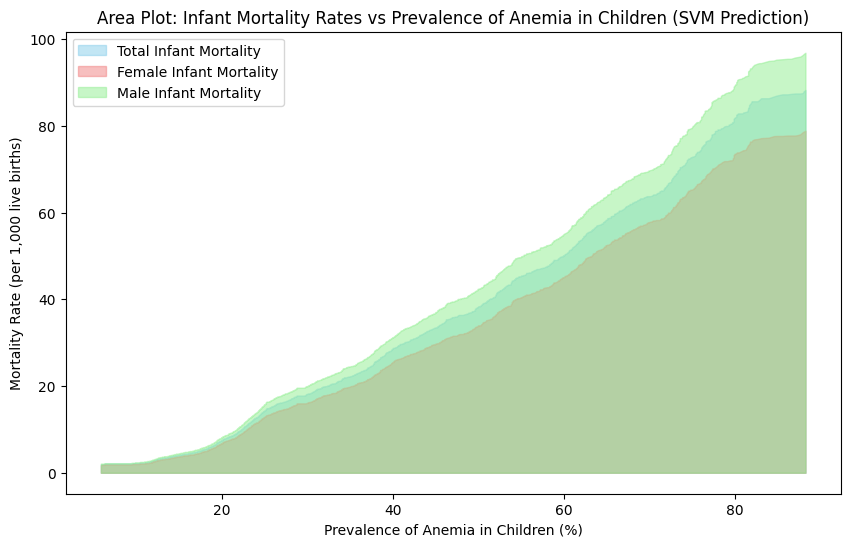

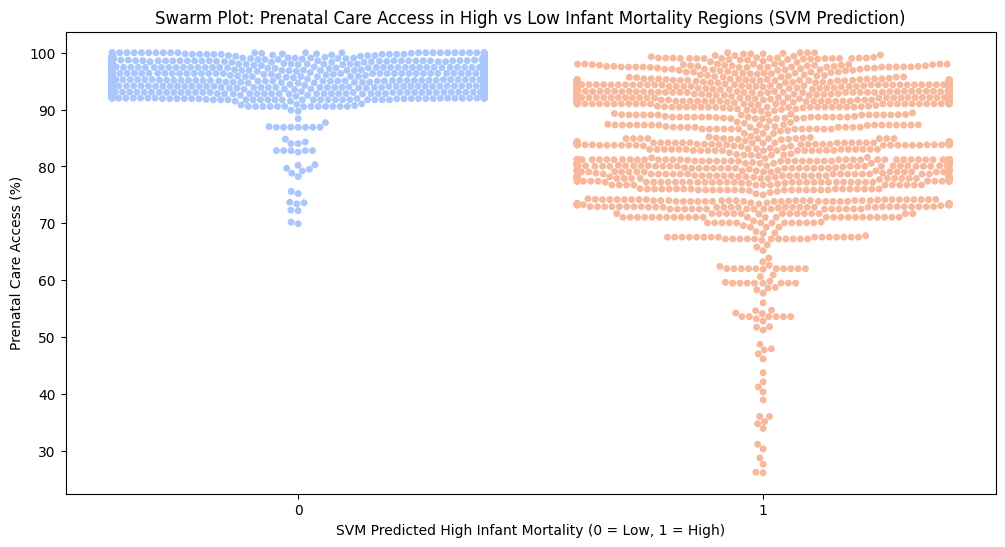

In [12]:
#Support Vector Machine Implementation for Problem 1 & it's respective hypothesis(1 & 2)
#Problem 1 & Hypothesis 1 & 2
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plot
import warnings
warnings.filterwarnings('ignore')

file_path = '/Users/sharanya/Downloads/phase3.csv' 

dataset_cleaned2 = pd.read_csv(file_path)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


hypothesis_1_data = dataset_cleaned2[['Mortality rate, infant (per 1,000 live births)',
                          'Mortality rate, infant, female (per 1,000 live births)',
                          'Mortality rate, infant, male (per 1,000 live births)',
                          'Prevalence of anemia among children (% of children ages 6-59 months)']].dropna()

hypothesis_2_data = dataset_cleaned2[['Prevalence of anemia among children (% of children ages 6-59 months)',
                          'Mortality rate, infant (per 1,000 live births)',
                          'Mortality rate, infant, female (per 1,000 live births)',
                          'Mortality rate, infant, male (per 1,000 live births)',
                          'Pregnant women receiving prenatal care (%)',
                          'Literacy rate, Pregnant Women (% of pregnant women ages 15 and above)',
                          'Hospital beds (per 1,000 people)',
                          'Physicians (per 1,000 people)']].dropna()


threshold_h1 = hypothesis_1_data['Mortality rate, infant (per 1,000 live births)'].median()
hypothesis_1_data['High_Infant_Mortality'] = (hypothesis_1_data['Mortality rate, infant (per 1,000 live births)'] >= threshold_h1).astype(int)

threshold_h2 = hypothesis_2_data['Mortality rate, infant (per 1,000 live births)'].median()
hypothesis_2_data['High_Infant_Mortality'] = (hypothesis_2_data['Mortality rate, infant (per 1,000 live births)'] >= threshold_h2).astype(int)

# Split features & target for each hypothesis
X1 = hypothesis_1_data[['Mortality rate, infant, female (per 1,000 live births)', 
                        'Mortality rate, infant, male (per 1,000 live births)', 
                        'Prevalence of anemia among children (% of children ages 6-59 months)']]
y1 = hypothesis_1_data['High_Infant_Mortality']

X2 = hypothesis_2_data[['Prevalence of anemia among children (% of children ages 6-59 months)', 
                        'Mortality rate, infant, female (per 1,000 live births)', 
                        'Mortality rate, infant, male (per 1,000 live births)', 
                        'Pregnant women receiving prenatal care (%)', 
                        'Literacy rate, Pregnant Women (% of pregnant women ages 15 and above)', 
                        'Hospital beds (per 1,000 people)', 
                        'Physicians (per 1,000 people)']]
y2 = hypothesis_2_data['High_Infant_Mortality']

# Standardize the known features
scaler1 = StandardScaler()
X1_scaled = scaler1.fit_transform(X1)

scaler2 = StandardScaler()
X2_scaled = scaler2.fit_transform(X2)

# SVM Model implementation for Hypothesis 1
svm_model1 = SVC(kernel='linear', probability=True)
svm_model1.fit(X1_scaled, y1)
y1_pred_svm = svm_model1.predict(X1_scaled)
accuracy1_svm = accuracy_score(y1, y1_pred_svm)
conf_matrix1_svm = confusion_matrix(y1, y1_pred_svm)
class_report1_svm = classification_report(y1, y1_pred_svm)

# SVM Model implementation for Hypothesis 2
svm_model2 = SVC(kernel='linear', probability=True)
svm_model2.fit(X2_scaled, y2)
y2_pred_svm = svm_model2.predict(X2_scaled)
accuracy2_svm = accuracy_score(y2, y2_pred_svm)
conf_matrix2_svm = confusion_matrix(y2, y2_pred_svm)
class_report2_svm = classification_report(y2, y2_pred_svm)

# Displaying SVM evaluation metrics for both hypotheses 1 & 2
print(accuracy1_svm)
print(conf_matrix1_svm)
print(class_report1_svm)

print(accuracy2_svm)
print(conf_matrix2_svm)
print(class_report2_svm)

#Below are the visualizations using Support Vector Machine (SVM) algorithms for Hypotheses 1 and 2.
import seaborn as sns
import matplotlib.pyplot as plot
import numpy as np
import pandas as pd

# Remove any NaN or infinite values 
hypothesis_1_data_cleaned = hypothesis_1_data.replace([np.inf, -np.inf], np.nan).dropna()

# Visualization 1: Area Plot for Hypothesis 1
# Sorting data for plotting
x = np.sort(hypothesis_1_data_cleaned['Prevalence of anemia among children (% of children ages 6-59 months)'])
y_total = np.sort(hypothesis_1_data_cleaned['Mortality rate, infant (per 1,000 live births)'])
y_female = np.sort(hypothesis_1_data_cleaned['Mortality rate, infant, female (per 1,000 live births)'])
y_male = np.sort(hypothesis_1_data_cleaned['Mortality rate, infant, male (per 1,000 live births)'])

# Plot area under the curve for infant mortality rates
plot.figure(figsize=(10, 6))
plot.fill_between(x, y_total, color='skyblue', alpha=0.5, label='Total Infant Mortality')
plot.fill_between(x, y_female, color='lightcoral', alpha=0.5, label='Female Infant Mortality')
plot.fill_between(x, y_male, color='lightgreen', alpha=0.5, label='Male Infant Mortality')

plot.title('Area Plot: Infant Mortality Rates vs Prevalence of Anemia in Children (SVM Prediction)')
plot.xlabel('Prevalence of Anemia in Children (%)')
plot.ylabel('Mortality Rate (per 1,000 live births)')
plot.legend()
plot.show()

# Visualization 2: Swarm Plot for Hypothesis 2
# Remove any NaN or infinite values
hypothesis_2_data_cleaned = hypothesis_2_data.replace([np.inf, -np.inf], np.nan).dropna()
hypothesis_2_data_cleaned['High_Infant_Mortality_SVM'] = y2_pred_svm  # Add SVM predictions for visualization

plot.figure(figsize=(12, 6))
sns.swarmplot(x='High_Infant_Mortality_SVM', 
              y='Pregnant women receiving prenatal care (%)', 
              data=hypothesis_2_data_cleaned, palette='coolwarm', edgecolor='k')
plot.title('Swarm Plot: Prenatal Care Access in High vs Low Infant Mortality Regions (SVM Prediction)')
plot.xlabel('SVM Predicted High Infant Mortality (0 = Low, 1 = High)')
plot.ylabel('Prenatal Care Access (%)')
plot.show()

ML, MR, and/or statistical modeling algorithms:

We used algorithms like Support Vector Machines (SVMs) and Logistic Regression in our investigation to generate informative visualizations that clearly demonstrate the answers to the following problems & it's respective hypothesis.

Problem 2. How does maternal hypertension correlate with low birthweight & infant mortality?

Hypothesis 1. Increased maternal hypertension is strongly related with higher rates of low birthweight & infant mortality rates. 
Hypothesis 2. Exposure to maternal healthcare services serves as a mediating factor in the correlation between low birthweight/infant mortality & maternal hypertension.

Note: Similar to problem 1, for the sake of clarity and a better understanding of algorithms, both SVM and logistic regression were used in order to compare the accuracy and other evaluation metrics. But, the primary algorithm to be considered for Problem 2 is SVM(Support Vector Machine)

0.8528864059590316
[[484  65]
 [ 93 432]]
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       549
           1       0.87      0.82      0.85       525

    accuracy                           0.85      1074
   macro avg       0.85      0.85      0.85      1074
weighted avg       0.85      0.85      0.85      1074

0.851024208566108
[[462  87]
 [ 73 452]]
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       549
           1       0.84      0.86      0.85       525

    accuracy                           0.85      1074
   macro avg       0.85      0.85      0.85      1074
weighted avg       0.85      0.85      0.85      1074



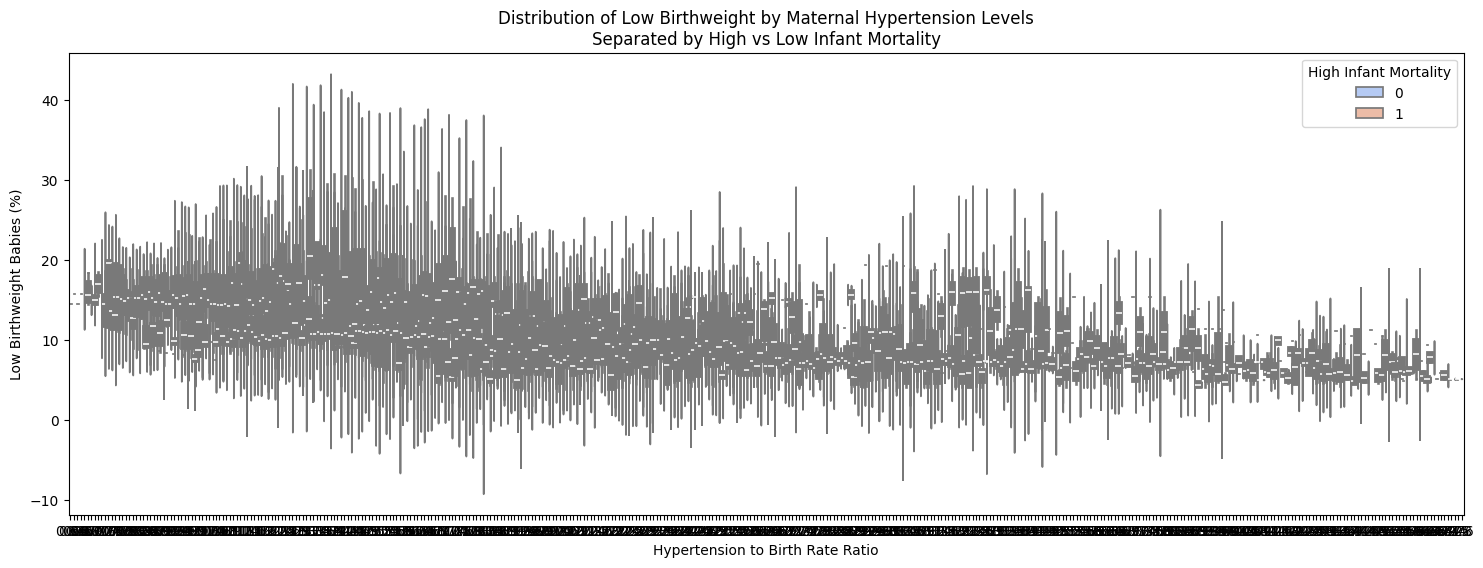

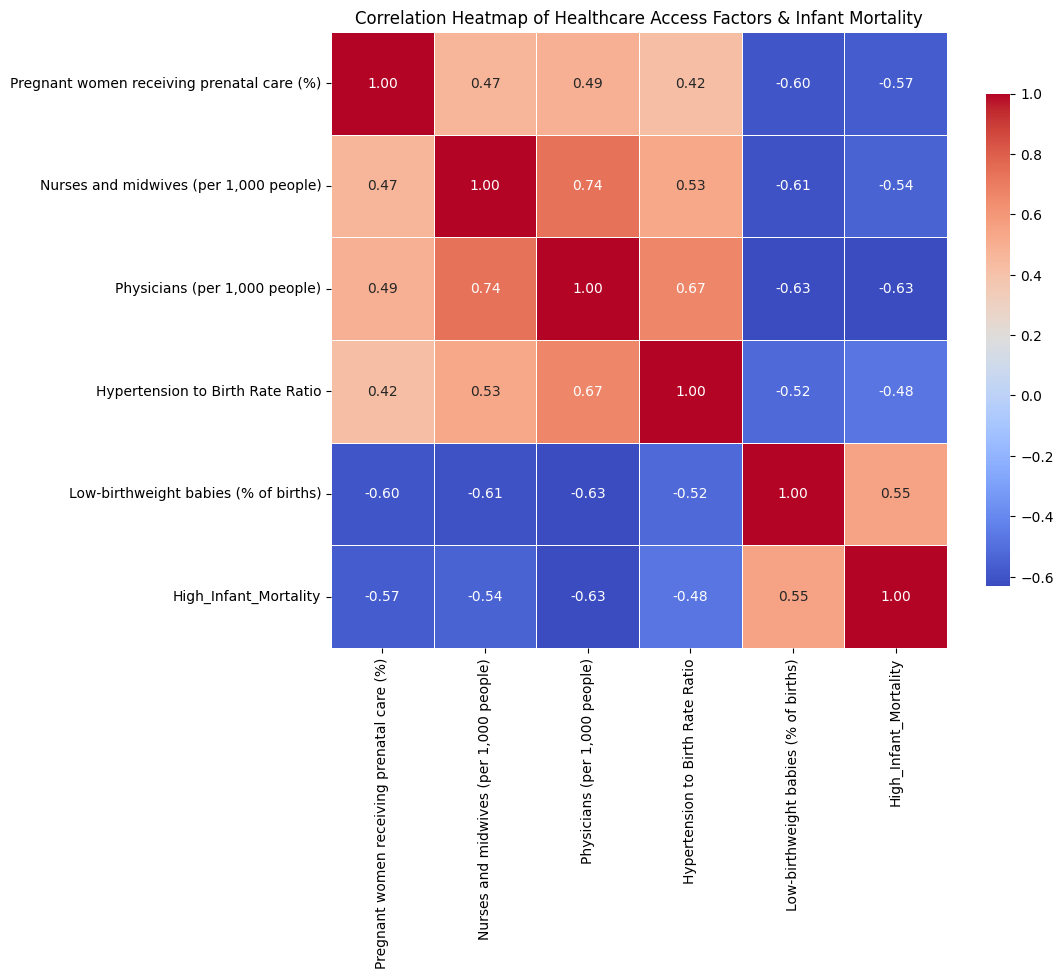

In [13]:
#Logistic Regression 
#Problem 1 & Hypothesis 1 & 2
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plot
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

file_path = '/Users/sharanya/Downloads/phase3.csv' 

dataset_cleaned2 = pd.read_csv(file_path)

hypothesis_1_data = dataset_cleaned2[['Hypertension to Birth Rate Ratio', 
                          'Infant Mortality Rate to Birth Rate Ratio', 
                          'Prevalence of hypertension, pregnant women (% of pregnant women adults ages 30-79)', 
                          'Low-birthweight babies (% of births)', 
                          'Life expectancy at birth, total (years)']]

hypothesis_2_data = dataset_cleaned2[['Pregnant women receiving prenatal care (%)', 
                          'Physicians (per 1,000 people)', 
                          'Nurses and midwives (per 1,000 people)', 
                          'Hypertension to Birth Rate Ratio', 
                          'Infant Mortality Rate to Birth Rate Ratio', 
                          'Prevalence of hypertension, pregnant women (% of pregnant women adults ages 30-79)', 
                          'Low-birthweight babies (% of births)']]

# Dropping rows with missing values
hypothesis_1_data = hypothesis_1_data.dropna()
hypothesis_2_data = hypothesis_2_data.dropna()

# Defining target variable for hypothesis 1
threshold = hypothesis_1_data['Infant Mortality Rate to Birth Rate Ratio'].median()
hypothesis_1_data['High_Infant_Mortality'] = (hypothesis_1_data['Infant Mortality Rate to Birth Rate Ratio'] >= threshold).astype(int)

# Features and target split for Hypothesis 1: Classifying based on the median
X1 = hypothesis_1_data[['Hypertension to Birth Rate Ratio', 
                        'Prevalence of hypertension, pregnant women (% of pregnant women adults ages 30-79)', 
                        'Low-birthweight babies (% of births)', 
                        'Life expectancy at birth, total (years)']]
y1 = hypothesis_1_data['High_Infant_Mortality']

# Logistic Regression Algorithm implentation for Hypothesis 1
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)
log_reg1 = LogisticRegression()
log_reg1.fit(X1_train, y1_train)
y1_pred = log_reg1.predict(X1_test)
accuracy1 = accuracy_score(y1_test, y1_pred)
conf_matrix1 = confusion_matrix(y1_test, y1_pred)
class_report1 = classification_report(y1_test, y1_pred)

# Displaying evaluation metrics for Hypothesis 1
print(accuracy1)
print(conf_matrix1)
print(class_report1)

# Defining target variable for hypothesis 2: classify as high vs low infant mortality based on the given median
threshold_h2 = hypothesis_2_data['Infant Mortality Rate to Birth Rate Ratio'].median()
hypothesis_2_data['High_Infant_Mortality'] = (hypothesis_2_data['Infant Mortality Rate to Birth Rate Ratio'] >= threshold_h2).astype(int)

# Features & target split for Hypothesis 2
X2 = hypothesis_2_data[['Pregnant women receiving prenatal care (%)', 
                        'Physicians (per 1,000 people)', 
                        'Nurses and midwives (per 1,000 people)', 
                        'Hypertension to Birth Rate Ratio', 
                        'Prevalence of hypertension, pregnant women (% of pregnant women adults ages 30-79)', 
                        'Low-birthweight babies (% of births)']]
y2 = hypothesis_2_data['High_Infant_Mortality']

# Logistic Regression Algorithm for Hypothesis 2
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)
log_reg2 = LogisticRegression()
log_reg2.fit(X2_train, y2_train)
y2_pred = log_reg2.predict(X2_test)
accuracy2 = accuracy_score(y2_test, y2_pred)
conf_matrix2 = confusion_matrix(y2_test, y2_pred)
class_report2 = classification_report(y2_test, y2_pred)

# Displaying evaluation metrics for Hypothesis 2
print(accuracy2)
print(conf_matrix2)
print(class_report2)

#Below are the visualizations using Logistic Regression algorithm for Hypotheses 1 and 2.
import seaborn as sns

# Violin Plot for Hypothesis 1:Graph for Low Birthweight vs Maternal Hypertension & Infant Mortality
plot.figure(figsize=(18, 6))
sns.violinplot(
    x='Hypertension to Birth Rate Ratio', 
    y='Low-birthweight babies (% of births)', 
    hue='High_Infant_Mortality', 
    data=hypothesis_1_data, 
    split=True,  # Splits the violin plot by hue (high vs low infant mortality)
    palette='coolwarm'
)
plot.title('Distribution of Low Birthweight by Maternal Hypertension Levels\nSeparated by High vs Low Infant Mortality')
plot.xlabel('Hypertension to Birth Rate Ratio')
plot.ylabel('Low Birthweight Babies (%)')
plot.legend(title='High Infant Mortality')
plot.show()

import numpy as np

# Calculating correlation matrix for healthcare access factors & infant mortality
corr_matrix = hypothesis_2_data[['Pregnant women receiving prenatal care (%)', 
                                 'Nurses and midwives (per 1,000 people)', 
                                 'Physicians (per 1,000 people)', 
                                 'Hypertension to Birth Rate Ratio', 
                                 'Low-birthweight babies (% of births)', 
                                 'High_Infant_Mortality']].corr()

# Heatmap for Hypothesis 2: Correlation between Healthcare Access & Infant Mortality
plot.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    cmap='coolwarm', 
    square=True, 
    cbar_kws={'shrink': 0.8}, 
    linewidths=0.5, 
    fmt=".2f"
)
plot.title('Correlation Heatmap of Healthcare Access Factors & Infant Mortality')
plot.show()

0.8510340972610397
[[1576  207]
 [ 326 1469]]
              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1783
           1       0.88      0.82      0.85      1795

    accuracy                           0.85      3578
   macro avg       0.85      0.85      0.85      3578
weighted avg       0.85      0.85      0.85      3578

0.8622135271101173
[[1498  285]
 [ 208 1587]]
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1783
           1       0.85      0.88      0.87      1795

    accuracy                           0.86      3578
   macro avg       0.86      0.86      0.86      3578
weighted avg       0.86      0.86      0.86      3578



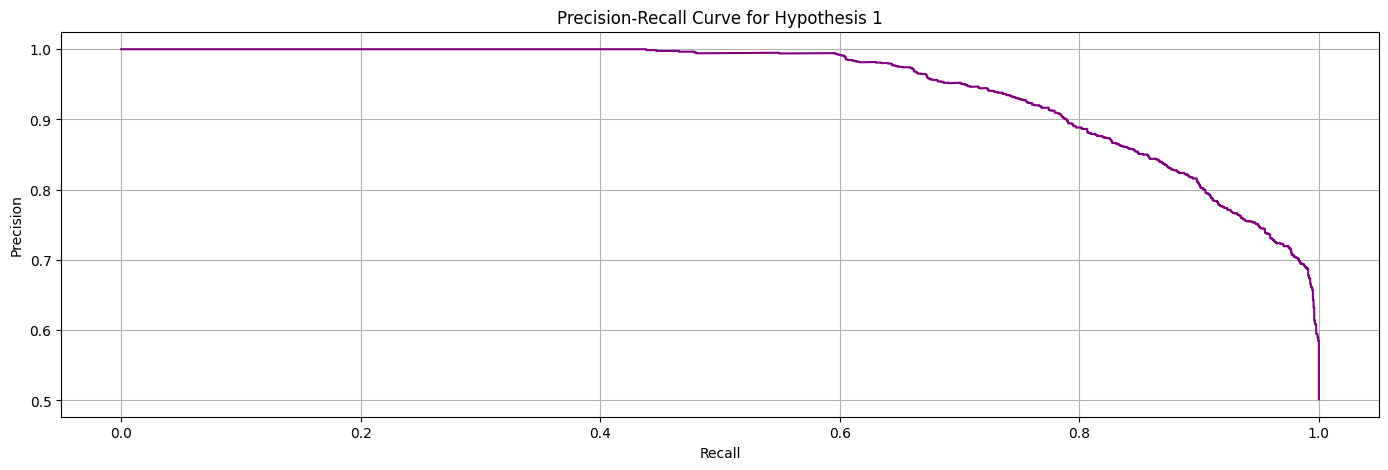

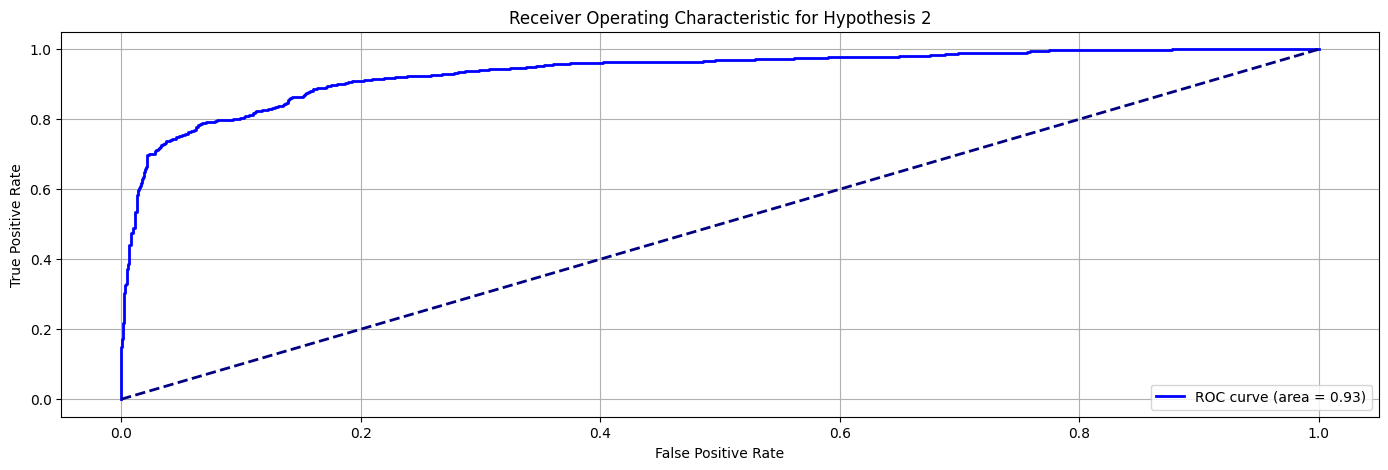

In [14]:
#Support Vector Machine Implementation for Problem 2 & it's respective hypothesis(1 & 2)
#Problem 2 & Hypothesis 1 & 2
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plot
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

file_path = '/Users/sharanya/Downloads/phase3.csv' 

dataset_cleaned2 = pd.read_csv(file_path)
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

# Standardizing the features for SVM Algorithm
scaler1 = StandardScaler()
X1_scaled = scaler1.fit_transform(X1)

scaler2 = StandardScaler()
X2_scaled = scaler2.fit_transform(X2)

# SVM Model for Hypothesis 1
svm_model1 = SVC(kernel='linear', probability=True)
svm_model1.fit(X1_scaled, y1)
y1_pred_svm = svm_model1.predict(X1_scaled)
accuracy1_svm = accuracy_score(y1, y1_pred_svm)
conf_matrix1_svm = confusion_matrix(y1, y1_pred_svm)
class_report1_svm = classification_report(y1, y1_pred_svm)

# SVM Model for Hypothesis 2
svm_model2 = SVC(kernel='linear', probability=True)
svm_model2.fit(X2_scaled, y2)
y2_pred_svm = svm_model2.predict(X2_scaled)
accuracy2_svm = accuracy_score(y2, y2_pred_svm)
conf_matrix2_svm = confusion_matrix(y2, y2_pred_svm)
class_report2_svm = classification_report(y2, y2_pred_svm)

# Displaying SVM evaluation metrics for both hypotheses 1 & 2
print(accuracy1_svm)
print(conf_matrix1_svm)
print(class_report1_svm)

print(accuracy2_svm)
print(conf_matrix2_svm)
print(class_report2_svm)

#Below are the visualizations using Support Vector Machine algorithm for Hypotheses 1 and 2.
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc

# Precision-Recall Curve for Hypothesis 1
#This will provide insight into the model's performance by displaying the trade-off between precision and recall for various thresholds.
y1_scores_svm = svm_model1.decision_function(X1_scaled)  
precision1, recall1, thresholds1 = precision_recall_curve(y1, y1_scores_svm)

plot.figure(figsize=(17,5))
plot.plot(recall1, precision1, color='purple')
plot.title('Precision-Recall Curve for Hypothesis 1')
plot.xlabel('Recall')
plot.ylabel('Precision')
plot.grid()
plot.show()

# ROC Curve for Hypothesis 2
# The SVM model's classification performance may be analyzed by comparing the true positive rate 
# & false positive rate at various thresholds using the ROC Curve with AUC (Area Under Curve).
y2_scores_svm = svm_model2.decision_function(X2_scaled)
fpr2, tpr2, _ = roc_curve(y2, y2_scores_svm)
roc_auc2 = auc(fpr2, tpr2)

plot.figure(figsize=(17,5))
plot.plot(fpr2, tpr2, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc2)
plot.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plot.xlabel('False Positive Rate')
plot.ylabel('True Positive Rate')
plot.title('Receiver Operating Characteristic for Hypothesis 2')
plot.legend(loc="lower right")
plot.grid()
plot.show()

Student Name: Anchal Daga
Student ID: 50609480
Mail ID: anchalda@buffalo.edu

Exploratory data analysis (EDA):

The questions & hypothesis taken into account for the EDA are listed below:

Question 1: Does the incidence of anemia in pregnant women connect with the prevalence of anemia in newborns, and how is this relationship impacted by maternal nutrition programs or availability to qualified medical personnel?

Hypothesis 1: A higher prevalence of anemia among pregnant women will correlate with an increased prevalence of anemia in infants.
Hypothesis 2: In a region, those with greater percentages of deliveries attended by experienced health workers would display lower rates of anemia in infants

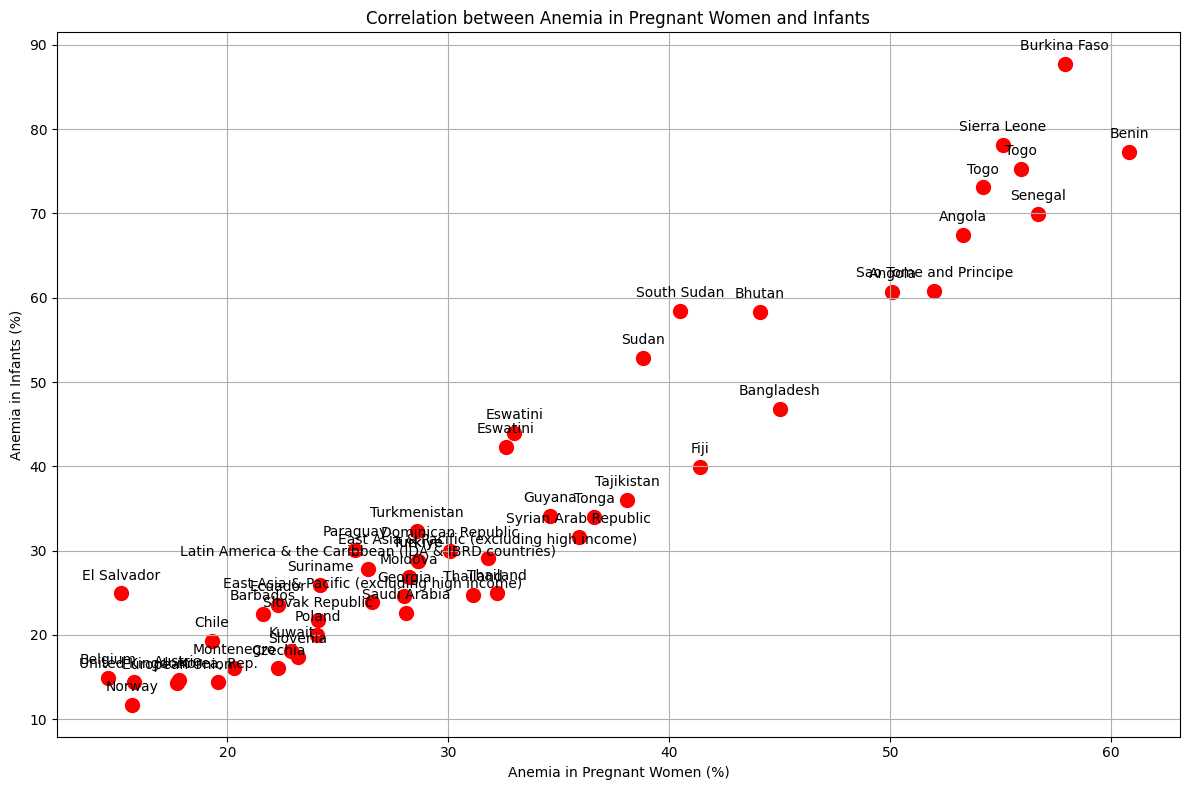

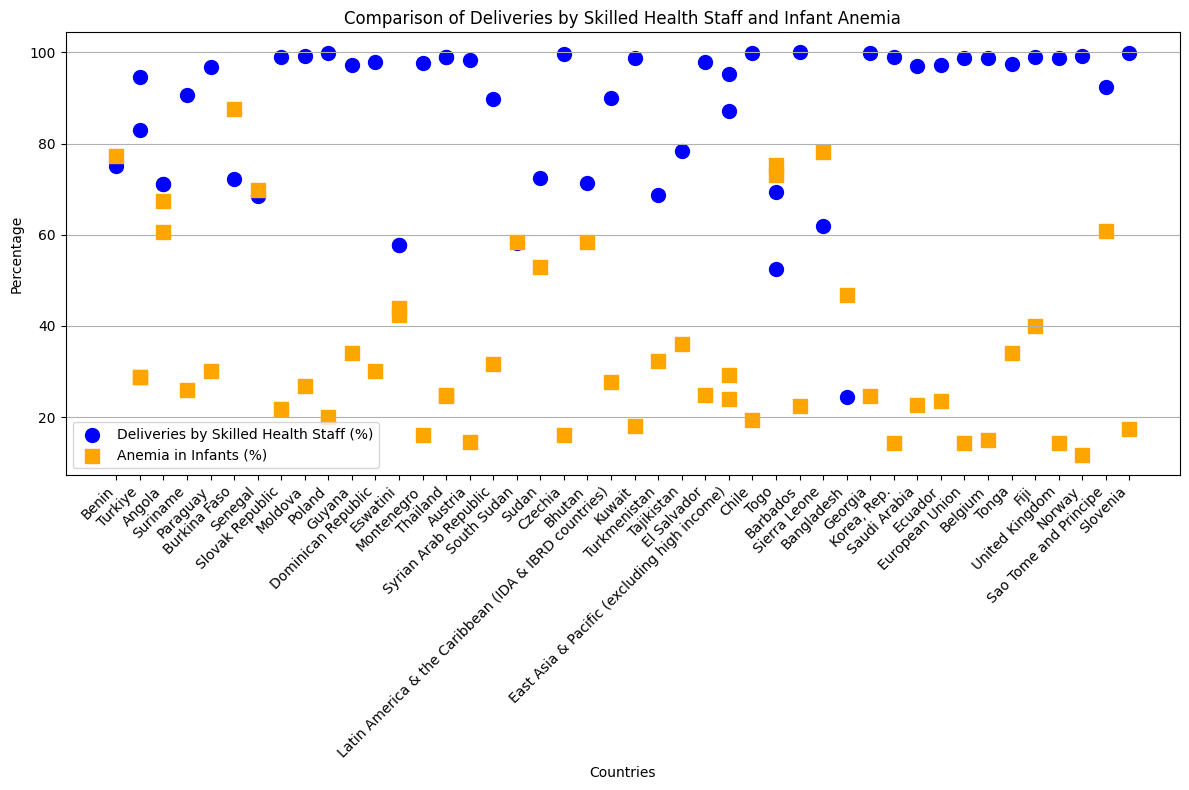

In [15]:
#Problem 1
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_path = '/Users/sharanya/Downloads/phase3.csv'
data = pd.read_csv(file_path)

#Hypothesis 1: A higher prevalence of anemia among pregnant women will correlate with an increased prevalence of anemia in infants.
data_sample = data.sample(n=50, random_state=1)  
countries = data_sample['Region Name']
anemia_mothers = data_sample['Prevalence of anemia among pregnant women (%)']
anemia_infants = data_sample['Prevalence of anemia among children (% of children ages 6-59 months)']

plt.figure(figsize=(12, 8))
plt.scatter(anemia_mothers, anemia_infants, color='red', s=100)

plt.title('Correlation between Anemia in Pregnant Women and Infants')
plt.xlabel('Anemia in Pregnant Women (%)')
plt.ylabel('Anemia in Infants (%)')

for i, country in enumerate(countries):
    plt.annotate(country, (anemia_mothers.iloc[i], anemia_infants.iloc[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.grid(True)
plt.tight_layout()
plt.show()

#Hypothesis 2: In a region, those with greater percentages of deliveries attended by experienced health workers would display lower rates of anemia in infants.
countries = data_sample['Region Name']
skilled_docs = data_sample['Births attended by skilled health staff (% of total)']
infants = data_sample['Prevalence of anemia among children (% of children ages 6-59 months)']

# Removing countries with zero values
valid_data = data_sample[(skilled_docs > 0) & (infants > 0)]

countries_filtered = valid_data['Region Name']
skilled_docs_filtered = valid_data['Births attended by skilled health staff (% of total)']
infants_filtered = valid_data['Prevalence of anemia among children (% of children ages 6-59 months)']


plt.figure(figsize=(12, 8))


plt.scatter(countries_filtered, skilled_docs_filtered, marker='o', label='Deliveries by Skilled Health Staff (%)', color='blue', s=100)

plt.scatter(countries_filtered, infants_filtered, marker='s', label='Anemia in Infants (%)', color='orange', s=100)

plt.title('Comparison of Deliveries by Skilled Health Staff and Infant Anemia')
plt.xlabel('Countries')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.legend()


plt.grid(axis='y')
plt.tight_layout()
plt.show()

Exploratory data analysis (EDA):

The questions & hypothesis taken into account for the EDA are listed below:

Question 2: What is the relationship between hospital infrastructure and the rates of stillbirths and neonatal deaths in different nations?

Hypothesis 1 : In China, higher hospital resources will be associated with lower rates of neonatal deaths and stillbirths.
Hypothesis 2: In Ghana, higher hospital resources will be associated with lower rates of neonatal deaths and stillbirths.

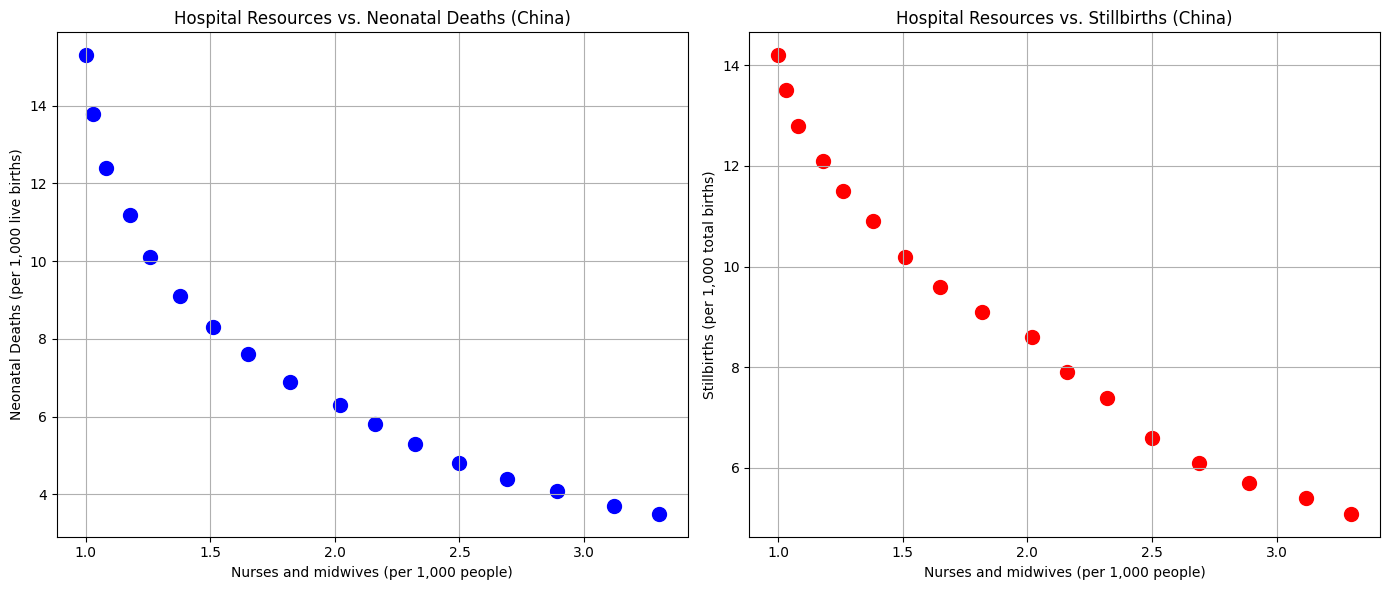

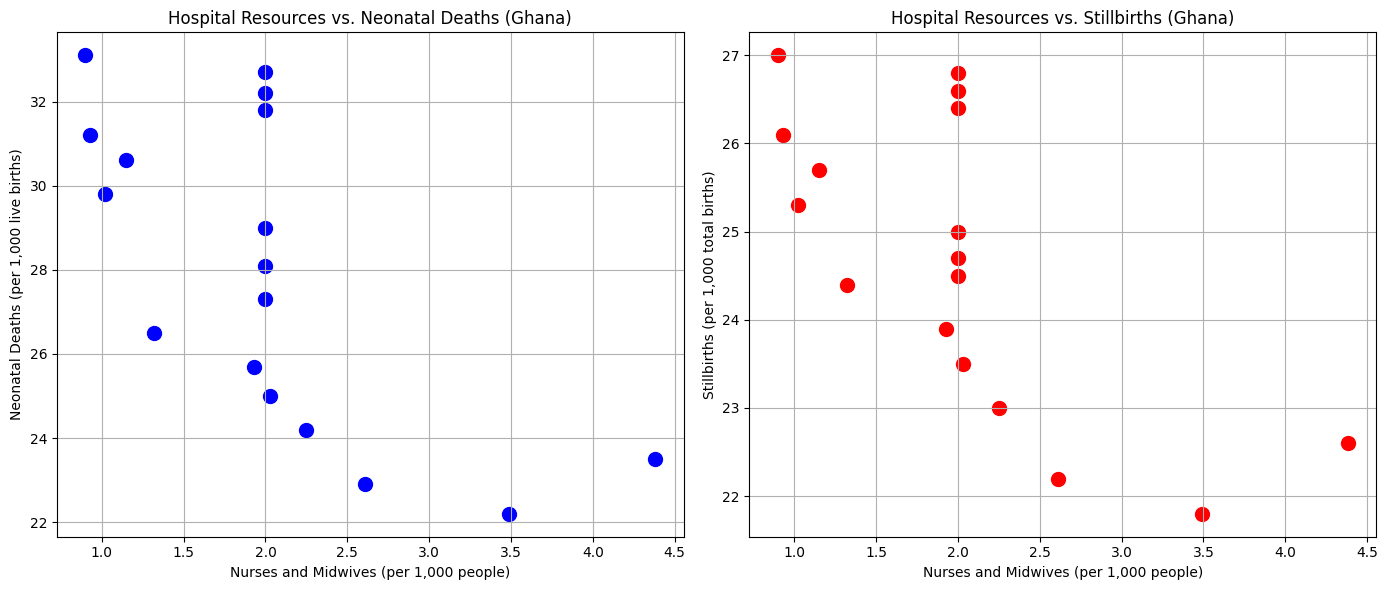

In [16]:
#Question 2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_path = '/Users/sharanya/Downloads/phase3.csv'
data = pd.read_csv(file_path)

#Hypothesis 1 : In China, higher hospital resources will be associated with lower rates of neonatal deaths and stillbirths.
china_data = data[data['Region Name'] == 'China']


china_data = china_data[['Nurses and midwives (per 1,000 people)', 'Mortality rate, neonatal (per 1,000 live births)', 
                     'Stillbirth rate (per 1,000 total births)']].dropna()


hospital_beds = china_data['Nurses and midwives (per 1,000 people)']
neonatal_deaths = china_data['Mortality rate, neonatal (per 1,000 live births)']
stillbirths = china_data['Stillbirth rate (per 1,000 total births)']


plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(hospital_beds, neonatal_deaths, color='blue', s=100)
plt.title('Hospital Resources vs. Neonatal Deaths (China)')
plt.xlabel('Nurses and midwives (per 1,000 people)')
plt.ylabel('Neonatal Deaths (per 1,000 live births)')
plt.grid(True)


plt.subplot(1, 2, 2)
plt.scatter(hospital_beds, stillbirths, color='red', s=100)
plt.title('Hospital Resources vs. Stillbirths (China)')
plt.xlabel('Nurses and midwives (per 1,000 people)')
plt.ylabel('Stillbirths (per 1,000 total births)')
plt.grid(True)


plt.tight_layout()
plt.show()

#Hypothesis 2: In Ghana, higher hospital resources will be associated with lower rates of neonatal deaths and stillbirths.
ghana_data = data[data['Region Name'] == 'Ghana']

ghana_data = ghana_data[['Nurses and midwives (per 1,000 people)', 
                          'Mortality rate, neonatal (per 1,000 live births)', 
                          'Stillbirth rate (per 1,000 total births)']].dropna()


hospital_beds = ghana_data['Nurses and midwives (per 1,000 people)']
neonatal_deaths = ghana_data['Mortality rate, neonatal (per 1,000 live births)']
stillbirths = ghana_data['Stillbirth rate (per 1,000 total births)']


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(hospital_beds, neonatal_deaths, color='blue', s=100)
plt.title('Hospital Resources vs. Neonatal Deaths (Ghana)')
plt.xlabel('Nurses and Midwives (per 1,000 people)')
plt.ylabel('Neonatal Deaths (per 1,000 live births)')
plt.grid(True)


plt.subplot(1, 2, 2)
plt.scatter(hospital_beds, stillbirths, color='red', s=100)
plt.title('Hospital Resources vs. Stillbirths (Ghana)')
plt.xlabel('Nurses and Midwives (per 1,000 people)')
plt.ylabel('Stillbirths (per 1,000 total births)')
plt.grid(True)

plt.tight_layout()
plt.show()

ML, MR, and/or statistical modeling algorithms:

Algorithm used: Gaussian Mixture Model

Question 1. Does the incidence of anemia in pregnant women connect with the prevalence of anemia in newborns, and how is this relationship impacted by maternal nutrition programs or availability to qualified medical personnel?

Variety of Hypotheses:

Hypothesis 1: A higher prevalence of anemia among pregnant women will correlate with an increased prevalence of anemia in infants.
Hypothesis 2: In a region, those with greater percentages of deliveries attended by experienced health workers would display lower rates of anemia in infants.

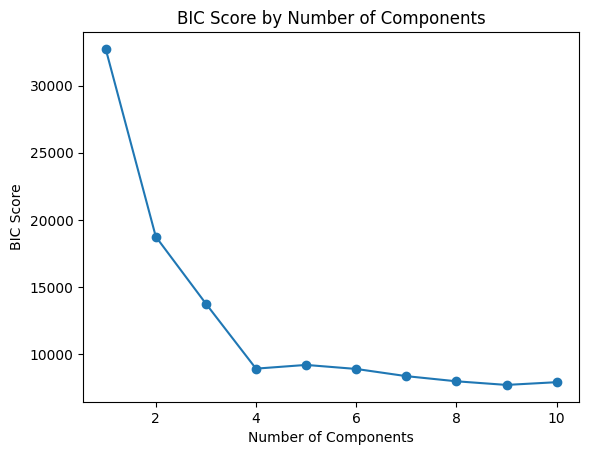

Cluster Means:
         Prevalence of anemia among pregnant women (%)  \
Cluster                                                  
0                                            25.143453   
1                                            40.927632   
2                                            34.561793   
3                                            49.163354   
4                                            55.203654   
5                                            19.027208   
6                                            53.453761   
7                                            38.329182   
8                                            41.170000   

         Prevalence of anemia among children (% of children ages 6-59 months)  \
Cluster                                                                         
0                                                23.936876                      
1                                                54.139430                      
2                     

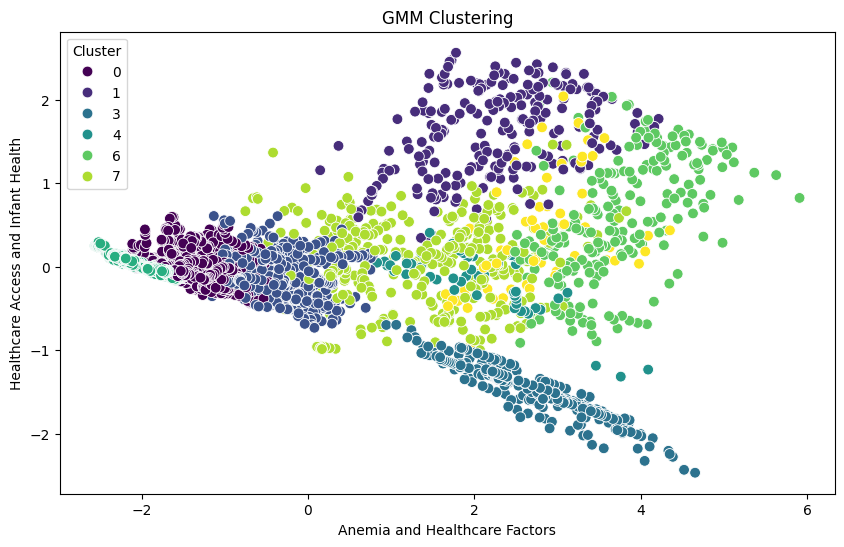

T-test between Cluster 3 and Cluster 4 for Infant Anemia: t-statistic=-1.0158231969836977, p-value=0.31036333425939816
Means of the components:
[[-0.55620335 -0.57480036  0.6171185  -0.57290489 -0.49515754]
 [ 0.70883995  0.9751734  -0.4145241   0.90439302  2.3007859 ]
 [ 0.16299592 -0.08883814  0.36271522 -0.14136417 -0.24239416]
 [ 1.34006446  1.58116197 -1.57331234  1.66990436 -0.32917133]
 [ 1.81730689  1.65737348 -0.02738578  0.46803343  0.51441578]
 [-1.05026846 -1.03859428  0.74159514 -0.97250494 -0.73697579]
 [ 1.6584507   1.71896557 -1.47032902  1.51620019  1.91773475]
 [ 0.46386357  0.45542071 -0.73435805  0.56768952  0.54605695]
 [ 0.65871308  0.58721851 -2.4718915   0.95344949  1.6438753 ]]
Covariances of the components:
[[[ 1.35645775e-01  5.08447026e-02 -8.34631894e-03  1.02874117e-02
   -7.50827295e-03]
  [ 5.08447026e-02  5.20568839e-02 -9.37263317e-03  2.52653574e-02
    3.84221289e-03]
  [-8.34631894e-03 -9.37263317e-03  4.45370578e-02 -1.67629669e-02
   -1.42557136e-

In [17]:
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import scipy.stats as stats

file_path = '/Users/sharanya/Downloads/phase3.csv' 
data = pd.read_csv(file_path)

#Getting features relevant to the hypotheses
df = data[['Prevalence of anemia among pregnant women (%)', 
           'Prevalence of anemia among children (% of children ages 6-59 months)', 
           'Births attended by skilled health staff (% of total)',
           'Mortality rate, infant (per 1,000 live births)', 
           'Maternal mortality ratio (modeled estimate, per 100,000 live births)']]

# Standardizing values
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)

# Calculating BIC score
bic_scores = []
for n_components in range(1, 11):  # Trying 1 to 10 clusters
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(data_scaled)
    bic_scores.append(gmm.bic(data_scaled))

plt.plot(range(1, 11), bic_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.title('BIC Score by Number of Components')
plt.show()

# optimal BIC score
optimal_components = bic_scores.index(min(bic_scores)) + 1
#print(f"Optimal number of components: {optimal_components}")

gmm = GaussianMixture(n_components=optimal_components, random_state=42)
gmm.fit(data_scaled)

#cluster labels
cluster_labels = gmm.predict(data_scaled)
df['Cluster'] = cluster_labels

cluster_means = df.groupby('Cluster').mean()
print("Cluster Means:")
print(cluster_means)

#Visualisation
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
data_2d = pca.fit_transform(data_scaled)

# Scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data_2d[:, 0], y=data_2d[:, 1], hue=cluster_labels, palette='viridis', s=60)
plt.xlabel('Anemia and Healthcare Factors')
plt.ylabel('Healthcare Access and Infant Health')
plt.title('GMM Clustering')
plt.legend(title='Cluster')
plt.show()

cluster_3 = df[df['Cluster'] == 3]['Prevalence of anemia among children (% of children ages 6-59 months)']
cluster_4 = df[df['Cluster'] == 4]['Prevalence of anemia among children (% of children ages 6-59 months)']

t_stat, p_value = stats.ttest_ind(cluster_3, cluster_4)
print(f"T-test between Cluster 3 and Cluster 4 for Infant Anemia: t-statistic={t_stat}, p-value={p_value}")

print("Means of the components:")
print(gmm.means_)

print("Covariances of the components:")
print(gmm.covariances_)

ML, MR, and/or statistical modeling algorithms:

Algorithm used: K- Means

Question 2. What is the relationship between hospital infrastructure and the rates of stillbirths and neonatal deaths in different nations?

Hypothesis 1 : In China, higher hospital resources will be associated with lower rates of neonatal deaths and stillbirths.
Hypothesis 2: In Ghana, higher hospital resources will be associated with lower rates of neonatal deaths and stillbirths.

China Cluster Centers:
[[-0.85952921  0.89259336  0.9191409 ]
 [ 0.76402596 -0.79341632 -0.81701413]]
Ghana Cluster Centers:
[[-1.11689304  6.6055381   5.89976564]
 [-0.29035919  4.84722848  4.95261327]]


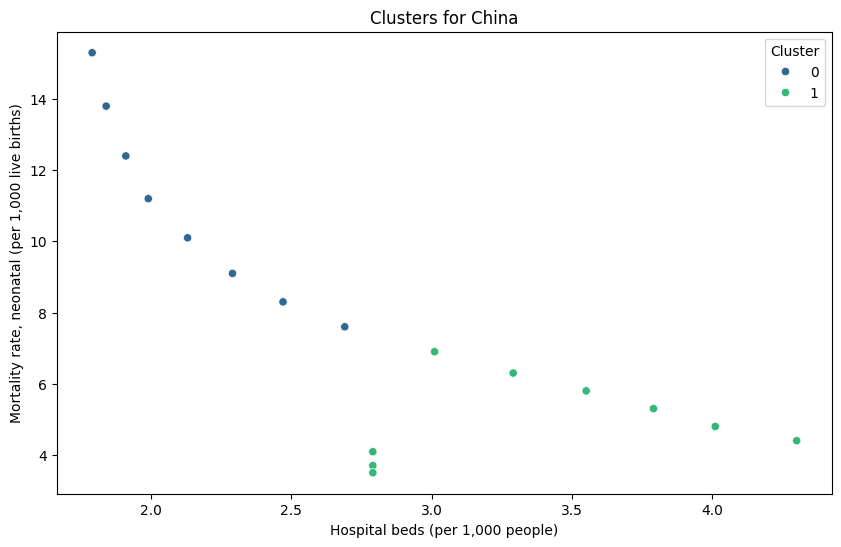

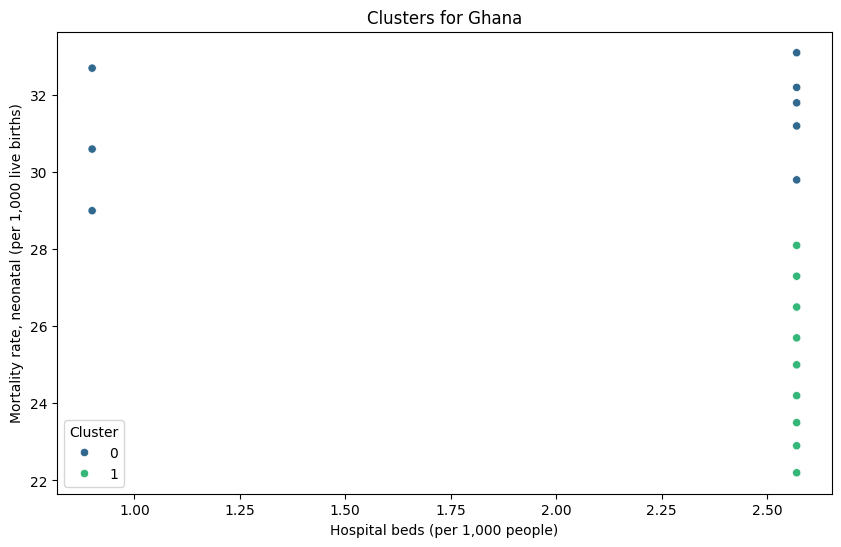

China Silhouette Score: 0.5501836208357939
Ghana Silhouette Score: 0.5068470669876897


In [18]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score

china_data = data[data['Region Name'] == 'China']
ghana_data = data[data['Region Name'] == 'Ghana']
china_features = china_data[['Hospital beds (per 1,000 people)', 'Mortality rate, neonatal (per 1,000 live births)', 'Stillbirth rate (per 1,000 total births)']]
ghana_features = ghana_data[['Hospital beds (per 1,000 people)', 'Mortality rate, neonatal (per 1,000 live births)', 'Stillbirth rate (per 1,000 total births)']]

# Standardizing features
scaler = StandardScaler()

china_scaled = scaler.fit_transform(china_features)
ghana_scaled = scaler.transform(ghana_features)


# Appling k means
kmeans_china = KMeans(n_clusters=2, random_state=42)
china_clusters = kmeans_china.fit_predict(china_scaled)
kmeans_ghana = KMeans(n_clusters=2, random_state=42)
ghana_clusters = kmeans_ghana.fit_predict(ghana_scaled)

china_data['Cluster'] = china_clusters
ghana_data['Cluster'] = ghana_clusters

# Cluster centers for China
print("China Cluster Centers:")
print(kmeans_china.cluster_centers_)

# Cluster centers for Ghana
print("Ghana Cluster Centers:")
print(kmeans_ghana.cluster_centers_)

# Plot for China
plt.figure(figsize=(10, 6))
sns.scatterplot(x=china_data['Hospital beds (per 1,000 people)'], y=china_data['Mortality rate, neonatal (per 1,000 live births)'], hue=china_data['Cluster'], palette="viridis")
plt.title("Clusters for China")
plt.xlabel("Hospital beds (per 1,000 people)")
plt.ylabel("Mortality rate, neonatal (per 1,000 live births)")
plt.show()

# Plot for Ghana
plt.figure(figsize=(10, 6))
sns.scatterplot(x=ghana_data['Hospital beds (per 1,000 people)'], y=ghana_data['Mortality rate, neonatal (per 1,000 live births)'], hue=ghana_data['Cluster'], palette="viridis")
plt.title("Clusters for Ghana")
plt.xlabel("Hospital beds (per 1,000 people)")
plt.ylabel("Mortality rate, neonatal (per 1,000 live births)")
plt.show()

# Silhouette score 
china_silhouette = silhouette_score(china_scaled, china_clusters)
ghana_silhouette = silhouette_score(ghana_scaled, ghana_clusters)

print("China Silhouette Score:", china_silhouette)
print("Ghana Silhouette Score:", ghana_silhouette)

Student Name: Grace Evangelene Avula Lael
Student ID: 50595809
Mail ID: graceeva@buffalo.edu

Exploratory data analysis (EDA):

The questions & hypothesis taken into account for the EDA are listed below:

Question 1: Does the availability of adequate healthcare resources reduce maternal and infant mortality rate?

Hypothesis 1 : An increased number of physicians and trained healthcare professionals, such as nurses and midwives, is linked to lower maternal mortality rates.

Hypothesis 2 : The presence of skilled health staff during childbirth, along with sufficient hospital bed capacity, significantly reduces both maternal and infant mortality rates. 

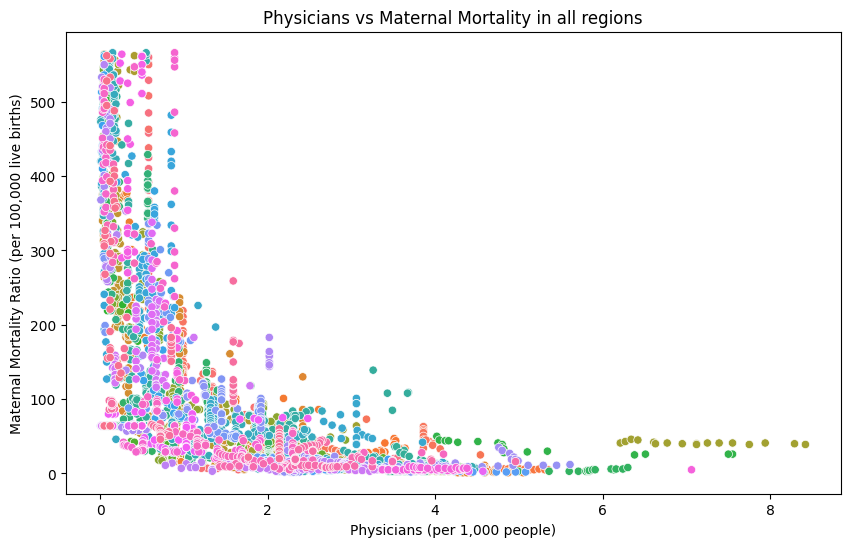

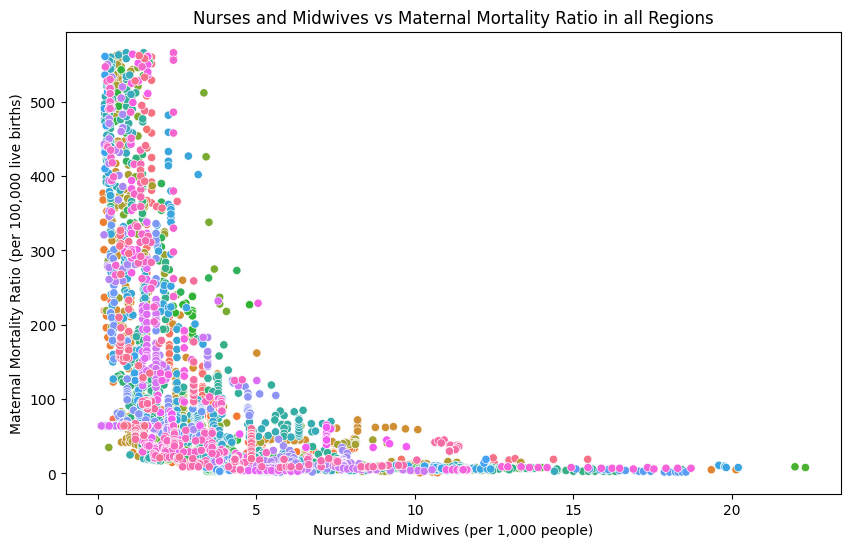

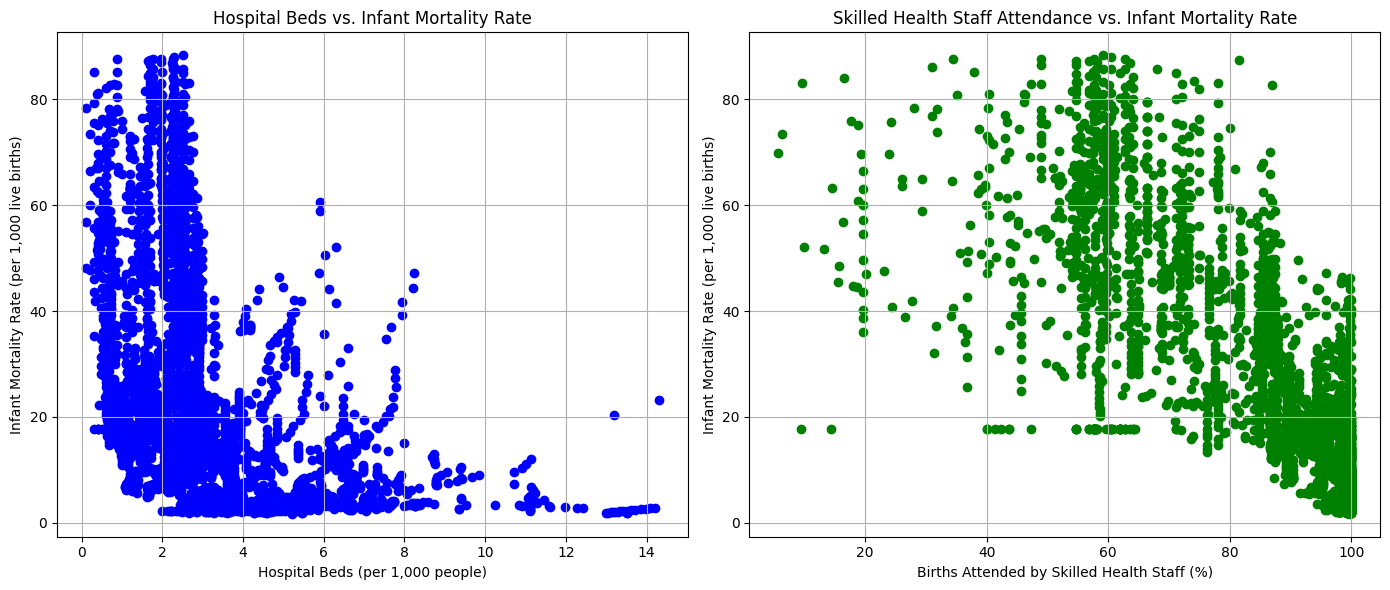

In [19]:
import pandas as pd
df = pd.read_csv('/Users/sharanya/Downloads/phase3.csv')

import matplotlib.pyplot as plt
import seaborn as sns

#Hypothesis 1
# Plot for physicians
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Physicians (per 1,000 people)', y='Maternal mortality ratio (modeled estimate, per 100,000 live births)', data=df, hue='Region Name',legend=False)
plt.title('Physicians vs Maternal Mortality in all regions')
plt.xlabel('Physicians (per 1,000 people)')
plt.ylabel('Maternal Mortality Ratio (per 100,000 live births)')
plt.show()

# Plot for nurses and midwives
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Nurses and midwives (per 1,000 people)', y='Maternal mortality ratio (modeled estimate, per 100,000 live births)', data=df, hue='Region Name', legend=False)
plt.title('Nurses and Midwives vs Maternal Mortality Ratio in all Regions')
plt.xlabel('Nurses and Midwives (per 1,000 people)')
plt.ylabel('Maternal Mortality Ratio (per 100,000 live births)')
plt.show()

#Hypothesis 2
# Plot 1: Hospital Beds vs. Infant Mortality Rate
plt.figure(figsize=(14, 6))

# Scatter plot for hospital beds vs. infant mortality
plt.subplot(1, 2, 1)
plt.scatter(df['Hospital beds (per 1,000 people)'], df['Mortality rate, infant (per 1,000 live births)'], color='blue')
plt.title('Hospital Beds vs. Infant Mortality Rate')
plt.xlabel('Hospital Beds (per 1,000 people)')
plt.ylabel('Infant Mortality Rate (per 1,000 live births)')
plt.grid(True)

# Plot 2: Skilled Professionals at Birth vs. Infant Mortality Rate
plt.subplot(1, 2, 2)
plt.scatter(df['Births attended by skilled health staff (% of total)'], df['Mortality rate, infant (per 1,000 live births)'], color='green')
plt.title('Skilled Health Staff Attendance vs. Infant Mortality Rate')
plt.xlabel('Births Attended by Skilled Health Staff (%)')
plt.ylabel('Infant Mortality Rate (per 1,000 live births)')
plt.grid(True)

# Show plots
plt.tight_layout()
plt.show()

Exploratory data analysis (EDA):

The questions & hypothesis taken into account for the EDA are listed below:

Question 2: How does women literacy rate influence healthcare during pregnancy and the child’s life?

Hypothesis 1: In communities with higher literacy rates, mothers are more particular about ensuring their children receive vaccinations, leading to improved immunization rates.

Hypothesis 2: Higher literacy rates among women are associated with lower engagement in high-risk behaviours, such as tobacco use, during pregnancy.


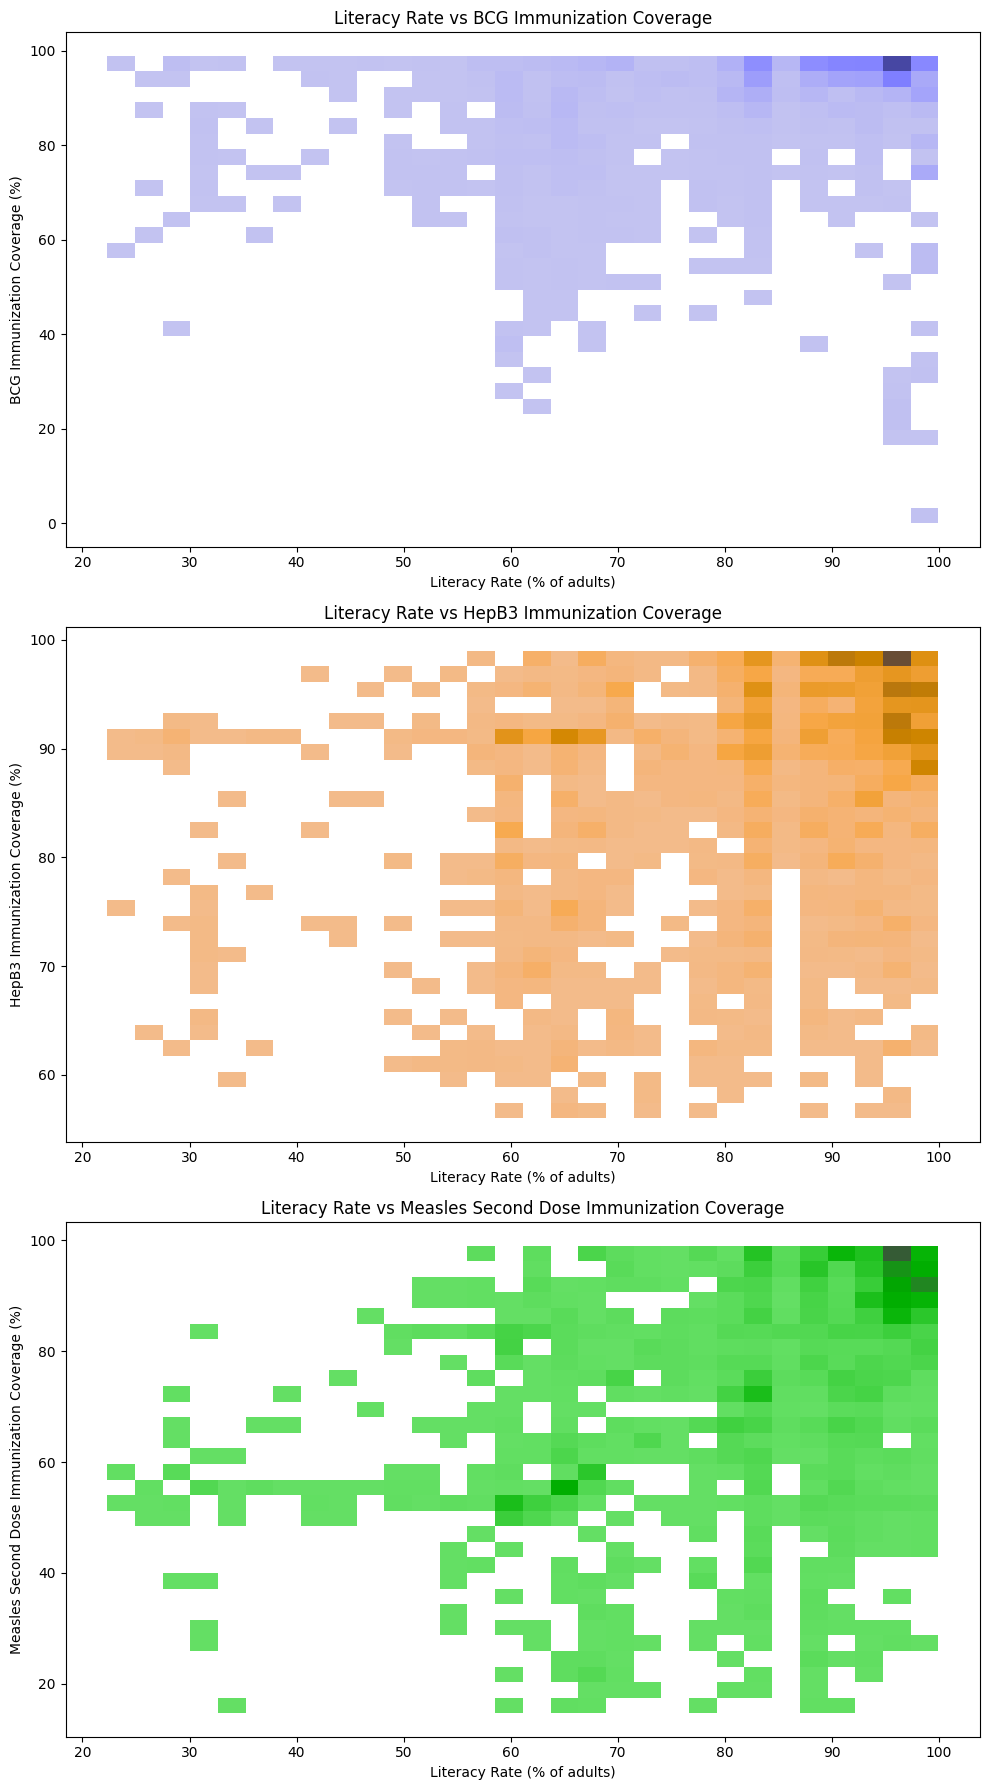

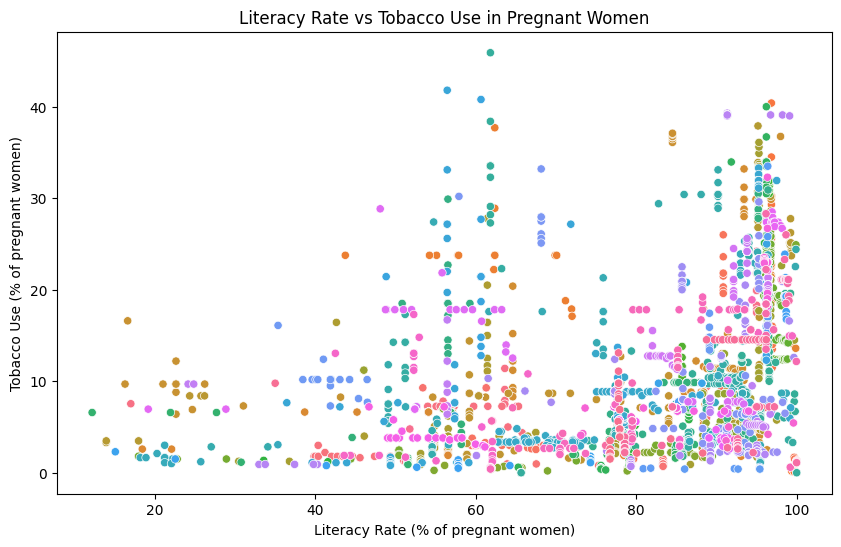

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/Users/sharanya/Downloads/phase3.csv')

# Hypothesis 1: In communities with higher literacy rates, mothers are more particular about ensuring their children receive vaccinations, leading to improved immunization rates.
# Set up the figure for histograms
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

# Histogram for BCG Immunization
sns.histplot(data=df, x='Literacy rate, adult total (% of people ages 15 and above)', 
             y='Immunization, BCG (% of one-year-old children)', 
             ax=axes[0], bins=30, color='blue', kde=True)
axes[0].set_title('Literacy Rate vs BCG Immunization Coverage')
axes[0].set_xlabel('Literacy Rate (% of adults)')
axes[0].set_ylabel('BCG Immunization Coverage (%)')

# Histogram for HepB3 Immunization
sns.histplot(data=df, x='Literacy rate, adult total (% of people ages 15 and above)', 
             y='Immunization, HepB3 (% of one-year-old children)', 
             ax=axes[1], bins=30, color='orange', kde=True)
axes[1].set_title('Literacy Rate vs HepB3 Immunization Coverage')
axes[1].set_xlabel('Literacy Rate (% of adults)')
axes[1].set_ylabel('HepB3 Immunization Coverage (%)')

# Histogram for Measles Second Dose Immunization
sns.histplot(data=df, x='Literacy rate, adult total (% of people ages 15 and above)', 
             y='Immunization, measles second dose (% of children by the nationally recommended age)', 
             ax=axes[2], bins=30, color='green', kde=True)
axes[2].set_title('Literacy Rate vs Measles Second Dose Immunization Coverage')
axes[2].set_xlabel('Literacy Rate (% of adults)')
axes[2].set_ylabel('Measles Second Dose Immunization Coverage (%)')

# Adjust layout
plt.tight_layout()
plt.show()

#Hypothesis 2: Higher literacy rates among women are associated with lower engagement in high-risk behaviours, such as tobacco use, during pregnancy.
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Literacy rate, Pregnant Women (% of pregnant women ages 15 and above)', y='Prevalence of current tobacco use, pregnant women (% of pregnant women adults)', data=df, hue='Region Name',legend=False)
plt.title('Literacy Rate vs Tobacco Use in Pregnant Women')
plt.xlabel('Literacy Rate (% of pregnant women)')
plt.ylabel('Tobacco Use (% of pregnant women)')
plt.show()

ML, MR, and/or statistical modeling algorithms:

Algorithm used: CNN & KNN

Checking Hypothesis-1(Life Expectancy) using K-nearest neighbours (KNN) and Convolutional Neural Networks (CNN)

Hypothesis 1: Availability of Medical resources, literacy rates, prevalance of diseases and mortality rates of a ceratin area directly affects the life expectancy either positively or negatively.

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

data = pd.read_csv('/Users/sharanya/Downloads/phase3.csv')


life_expectancy_features = [
    'Birth rate, crude (per 1,000 people)', 'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)',
    'Hospital beds (per 1,000 people)', 'Immunization, BCG (% of one-year-old children)', 
    'Literacy rate, adult total (% of people ages 15 and above)', 'Mortality rate, infant (per 1,000 live births)', 
    'Nurses and midwives (per 1,000 people)', 'Physicians (per 1,000 people)'
]
maternal_mortality_features = [
    'Birth rate, crude (per 1,000 people)', 'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)',
    'Hospital beds (per 1,000 people)', 'Lifetime risk of maternal death (%)', 
    'Literacy rate, adult total (% of people ages 15 and above)', 'Mortality rate, neonatal (per 1,000 live births)', 
    'Nurses and midwives (per 1,000 people)', 'Prevalence of anemia among pregnant women (%)'
]


X_life_expectancy = data[life_expectancy_features]
y_life_expectancy = data['Life expectancy at birth, total (years)']
X_maternal_mortality = data[maternal_mortality_features]
y_maternal_mortality = data['Maternal mortality ratio (modeled estimate, per 100,000 live births)']
X_train_life, X_test_life, y_train_life, y_test_life = train_test_split(X_life_expectancy, y_life_expectancy, test_size=0.2, random_state=42)
X_train_maternal, X_test_maternal, y_train_maternal, y_test_maternal = train_test_split(X_maternal_mortality, y_maternal_mortality, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_life = scaler.fit_transform(X_train_life)
X_test_life = scaler.transform(X_test_life)
X_train_maternal = scaler.fit_transform(X_train_maternal)
X_test_maternal = scaler.transform(X_test_maternal)

#Using CNN

model_life = Sequential()
model_life.add(Conv1D(64, 2, activation='relu', input_shape=(X_train_life.shape[1], 1)))
model_life.add(MaxPooling1D(2))
model_life.add(Conv1D(128, 2, activation='relu'))
model_life.add(MaxPooling1D(2))
model_life.add(Flatten())
model_life.add(Dense(64, activation='relu'))
model_life.add(Dense(1))
model_life.compile(optimizer=Adam(), loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_life = model_life.fit(X_train_life, y_train_life, epochs=50, validation_split=0.2, batch_size=32, callbacks=[early_stopping])
y_test_life = np.array(y_test_life).reshape(-1, 1)

mse_life = model_life.evaluate(X_test_life, y_test_life)
print(f"Mean Squared Error for Life Expectancy Prediction with CNN: {mse_life}")

y_pred_life = model_life.predict(X_test_life)

features = [
    'Birth rate, crude (per 1,000 people)', 
    'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)',
    'Hospital beds (per 1,000 people)', 
    'Immunization, BCG (% of one-year-old children)', 
    'Literacy rate, adult total (% of people ages 15 and above)', 
    'Mortality rate, infant (per 1,000 live births)', 
    'Nurses and midwives (per 1,000 people)', 
    'Physicians (per 1,000 people)'
]

positive_features = [
    'Hospital beds (per 1,000 people)', 
    'Immunization, BCG (% of one-year-old children)', 
    'Literacy rate, adult total (% of people ages 15 and above)', 
    'Nurses and midwives (per 1,000 people)', 
    'Physicians (per 1,000 people)'
]
negative_features = [
    'Birth rate, crude (per 1,000 people)', 
    'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)',
    'Mortality rate, infant (per 1,000 live births)'
]

max_values = X_train_life.max(axis=0)

results = []

for i in range(10):  
    feature_values = X_test_life[i]  
    row = {
        'Expected Output': y_test_life[i][0],  
        'Predicted Output': y_pred_life[i][0],  
        'Life Expectancy': 'High' if y_pred_life[i][0] > 65 else 'Low'
    }
    
    positive_high_count = 0
    for feature in positive_features:
        feature_index = features.index(feature)
        if (feature_values[feature_index] / max_values[feature_index]) > 0.3:
            positive_high_count += 1
            
    negative_high_count = 0
    for feature in negative_features:
        feature_index = features.index(feature)
        if (feature_values[feature_index] / max_values[feature_index]) > 0.4:
            negative_high_count += 1

    row['Positive Features (High/Low)'] = 'High' if (positive_high_count / len(positive_features)) > 0.3 else 'Low'
    row['Negative Features (High/Low)'] = 'High' if (negative_high_count / len(negative_features)) > 0.3 else 'Low'
    results.append(row)

results_df = pd.DataFrame(results)
print("\nSample Predictions with Expected and Predicted Outputs:")
print(results_df)

#Using KNN

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_life, y_train_life)

y_pred_life = knn.predict(X_test_life)
y_test_life = np.array(y_test_life)
y_pred_life = np.array(y_pred_life)


mse_life = mean_squared_error(y_test_life, y_pred_life)
print(f"Mean Squared Error for Life Expectancy Prediction with KNN: {mse_life}")

features = [
    'Birth rate, crude (per 1,000 people)', 
    'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)',
    'Hospital beds (per 1,000 people)', 
    'Immunization, BCG (% of one-year-old children)', 
    'Literacy rate, adult total (% of people ages 15 and above)', 
    'Mortality rate, infant (per 1,000 live births)', 
    'Nurses and midwives (per 1,000 people)', 
    'Physicians (per 1,000 people)'
]

positive_features = [
    'Hospital beds (per 1,000 people)', 
    'Immunization, BCG (% of one-year-old children)', 
    'Literacy rate, adult total (% of people ages 15 and above)', 
    'Nurses and midwives (per 1,000 people)', 
    'Physicians (per 1,000 people)'
]
negative_features = [
    'Birth rate, crude (per 1,000 people)', 
    'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)',
    'Mortality rate, infant (per 1,000 live births)'
]

max_values = X_train_life.max(axis=0)
results = []

for i in range(10): 
    feature_values = X_test_life[i] 
    row = {
        'Expected Output': y_test_life[i],
        'Predicted Output': y_pred_life[i],
        'Life Expectancy': 'High' if y_pred_life[i] > 65 else 'Low'
    }
       
    positive_high_count = 0
    for feature in positive_features:
        feature_index = features.index(feature)
        if (feature_values[feature_index] / max_values[feature_index]) > 0.3:
            positive_high_count += 1
            
    negative_high_count = 0
    for feature in negative_features:
        feature_index = features.index(feature)
        if (feature_values[feature_index] / max_values[feature_index]) > 0.4:
            negative_high_count += 1

    row['Positive Features (High/Low)'] = 'High' if (positive_high_count / len(positive_features)) > 0.3 else 'Low'
    row['Negative Features (High/Low)'] = 'High' if (negative_high_count / len(negative_features)) > 0.3 else 'Low'
    
    results.append(row)

results_df = pd.DataFrame(results)
print(results_df)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
for feature in positive_features:
    plt.scatter(X_test_life[:, features.index(feature)], y_pred_life, label=feature)

plt.title('Impact of Positive Features on Life Expectancy')
plt.xlabel('Feature Values')
plt.ylabel('Predicted Life Expectancy')
plt.axhline(y=65, color='r', linestyle='--', label='Threshold for High Life Expectancy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
for feature in negative_features:
    plt.scatter(X_test_life[:, features.index(feature)], y_pred_life, label=feature)

plt.title('Impact of Negative Features on Life Expectancy')
plt.xlabel('Feature Values')
plt.ylabel('Predicted Life Expectancy')
plt.axhline(y=65, color='r', linestyle='--', label='Threshold for High Life Expectancy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'tensorflow'

ML, MR, and/or statistical modeling algorithms:

Algorithm used: CNN & KNN

Checking Hypothesis-2(Maternal Mortality) using Knn and Cnn

Hypothesis 2: Maternal mortality rate can be estimated by the levels of Birth rates, Literacy rate, medical resources and health coditions.

In [22]:
#Using Cnn

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error


mlp = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_maternal.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  
])
mlp.compile(optimizer='adam', loss='mse')
history = mlp.fit(X_train_maternal, y_train_maternal, epochs=50, validation_split=0.2, batch_size=8, verbose=1)
y_pred_maternal = mlp.predict(X_test_maternal).flatten()
mse_maternal = mean_squared_error(y_test_maternal, y_pred_maternal)
print(f"Mean Squared Error for Maternal Mortality Ratio Prediction with MLP: {mse_maternal}")
max_values_maternal = X_train_maternal.max(axis=0)
results = []

for i in range(10):  
    feature_values = X_test_maternal[i]  
    row = {
        'Expected Output': y_test_maternal.iloc[i],  
        'Predicted Output': y_pred_maternal[i],
        'Maternal Mortality Ratio': 'High' if y_pred_maternal[i] > 150 else 'Low' 
    }
    
    high_count = 0 
       
    for j, feature in enumerate(maternal_mortality_features):
        feature_value = feature_values[j]
        max_value = max_values_maternal[j]
        feature_status = 'High' if (feature_value / max_value) > 0.2 else 'Low' 
        
        if feature_status == 'High':
            high_count += 1 

  
    row['Features'] = 'High' if high_count > len(maternal_mortality_features) / 3 else 'Low'
    results.append(row)


results_df = pd.DataFrame(results)
print("\nSample Predictions with Expected and Predicted Outputs:")
print(results_df)

#Using Knn
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_maternal, y_train_maternal)
y_pred_maternal = knn.predict(X_test_maternal)
mse_maternal = mean_squared_error(y_test_maternal, y_pred_maternal)
print(f"Mean Squared Error for Maternal Mortality Ratio Prediction with KNN: {mse_maternal}")


max_values_maternal = X_train_maternal.max(axis=0)
results = []


for i in range(10):  
    feature_values = X_test_maternal[i] 
    row = {
        'Expected Output': y_test_maternal.iloc[i], 
        'Predicted Output': y_pred_maternal[i],
        'Maternal Mortality Ratio': 'High' if y_pred_maternal[i] > 150 else 'Low'  
    }
    
    high_count = 0  
   
    for j, feature in enumerate(maternal_mortality_features):
        feature_value = feature_values[j]
        max_value = max_values_maternal[j]
        feature_status = 'High' if (feature_value / max_value) > 0.2 else 'Low'  
        
        if feature_status == 'High':
            high_count += 1  

    
    row['Features'] = 'High' if high_count > len(maternal_mortality_features) / 3 else 'Low'
    results.append(row)


results_df = pd.DataFrame(results)
print("\nSample Predictions with Expected and Predicted Outputs:")
print(results_df)
plt.figure(figsize=(20, 20))

for i, feature in enumerate(maternal_mortality_features):
    plt.subplot(4, 2, i + 1)  # Create a 2x4 grid for subplots
    plt.scatter(X_test_maternal[:, i], y_pred_maternal, alpha=0.6)
    plt.title(feature)
    plt.xlabel('Feature Value')
    plt.ylabel('Predicted Maternal Mortality Ratio')
    plt.axhline(y=150, color='r', linestyle='--', label='Threshold for High Maternal Mortality')
    plt.grid()
    plt.legend()

plt.tight_layout()
plt.show()

ModuleNotFoundError: No module named 'tensorflow'